# Defacing pre-registration - Exploratory analysis in R

First, we load some modules and the dataset

In [1]:
library(ggplot2)
library(dplyr)
library(tidyr)
library(grid)
library(gridExtra)
library(egg)
library(gifski)
library(gridtext)
library(ggtext)  # Support markdown in labels and text
library(see)
library(scales)
library(gganimate)

library(irr)
library(boot)
library(xtable)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Loading required package: lpSolve



In [ ]:
# Load ratings
df <- read.csv("../../data/S1_Data.tsv", sep = "\t")

df <- df %>%
  rename(is_defaced = defaced)

summary(df)

 randomized_id        rater_id           dataset              rating     
 Length:1800        Length:1800        Length:1800        Min.   :1.050  
 Class :character   Class :character   Class :character   1st Qu.:2.850  
 Mode  :character   Mode  :character   Mode  :character   Median :3.250  
                                                          Mean   :3.126  
                                                          3rd Qu.:3.550  
                                                          Max.   :4.000  
    time_sec        artifacts           confidence      comments        
 Min.   :  3.501   Length:1800        Min.   :0.000   Length:1800       
 1st Qu.: 35.850   Class :character   1st Qu.:3.500   Class :character  
 Median : 48.610   Mode  :character   Median :3.500   Mode  :character  
 Mean   : 59.782                      Mean   :3.349                     
 3rd Qu.: 68.335                      3rd Qu.:3.500                     
 Max.   :709.212                      Max.  

Let's verify that each rater rated all 450 images.

In [3]:
raters <- list('rater_01', 'rater_02', 'rater_03', 'rater_04')
for (rater in raters) {
  df_rater <- subset(df, rater_id == rater)
  # If an image was assigned several ratings by the same rater, we keep only the last one
  df_unique <- df_rater[!duplicated(df_rater[c("rater_id", "randomized_id")], fromLast = TRUE), ]
  print(paste(rater, ":", nrow(df_unique), "images rated"))
}

[1] "rater_01 : 450 images rated"
[1] "rater_02 : 450 images rated"
[1] "rater_03 : 450 images rated"
[1] "rater_04 : 450 images rated"


In [4]:
# Remove information we will not use in this analysis
df <- subset(df, select = c("rater_id", "rating", "is_defaced", "subject"))

# Add a column rater_label for pretty printing of the rater_id
df <- df %>%
  mutate(rater_label = gsub("rater_0", "Rater ", rater_id))

# See summary to chech issues
summary(df)

# Convert defaced to factor for better visualization
df$is_defaced <- factor(df$is_defaced, levels = c(0, 1), labels = c("nondefaced", "defaced"))

# Pivot to wide format
df_long <- df %>% pivot_wider(
  names_from = is_defaced,
  values_from = rating,
  values_fn = list
)

# Decouple the duplicates by writing the first image rating in one line
# and the second in a new line
df_long <- df_long %>%
  unnest(cols = c("nondefaced", "defaced"))

# Create mean, deltas columns
df_wide_ba <- df_long %>% mutate(
  mean = (nondefaced + defaced) / 2,
  deltas = nondefaced - defaced
)

   rater_id             rating        is_defaced     subject     
 Length:1800        Min.   :1.050   Min.   :0.0   Min.   : 12.0  
 Class :character   1st Qu.:2.850   1st Qu.:0.0   1st Qu.:167.0  
 Mode  :character   Median :3.250   Median :0.5   Median :313.0  
                    Mean   :3.126   Mean   :0.5   Mean   :334.8  
                    3rd Qu.:3.550   3rd Qu.:1.0   3rd Qu.:521.0  
                    Max.   :4.000   Max.   :1.0   Max.   :661.0  
 rater_label       
 Length:1800       
 Class :character  
 Mode  :character  
                   
                   
                   

### Biases and significance

In [5]:
# Function to compute bootstrap CI
bootstrap_ci <- function(data, R = 10000) {
  day <- 220830
  time <- 543417
  set.seed(day+time)
  boot_result <- boot(data = data, statistic = function(d, i) mean(d[i]), R = R)
  ci <- boot.ci(boot_result, type = "perc")$percent[4:5]
  return(ci)
}

# Function to compute ICC (Intraclass Correlation Coefficient)
compute_icc <- function(df) {
  icc_result <- icc(df[, c("nondefaced", "defaced")], model = "twoway", type = "agreement", unit = "single")
  icc_value <- round(icc_result$value, 3)
  icc_ci <- paste0("[", round(icc_result$lbound, 3), ", ", round(icc_result$ubound, 3), "]")
  
  return(c(
    `ICC` = icc_value,
    `95% CI (ICC)` = icc_ci
  ))
}

# Function to compute statistics for a given dataset
compute_stats <- function(df, two = 1.96) {
  n_samples <- nrow(df)
  bias <- mean(df$deltas, na.rm = TRUE)  # Mean difference
  sd_deltas <- sd(df$deltas, na.rm = TRUE)
  loa_lower <- bias - two * sd_deltas  # Lower 95% LoA
  loa_upper <- bias + two * sd_deltas  # Upper 95% LoA
  ci_parametric <- 1.96 * (sd_deltas / sqrt(nrow(df)))  # Parametric CI
  ci_nonparametric <- bootstrap_ci(df$deltas)  # Nonparametric CI
  icc_stats <- compute_icc(df)  # ICC calculation

  return(c(
    `n` = as.character(n_samples),
    Bias = round(bias, 3),
    `95% LoA` = paste0("[", round(loa_lower, 3), ", ", round(loa_upper, 3), "]"),
    `95% CI (Parametric)` = paste0("[", round(bias - ci_parametric, 3), ", ", round(bias + ci_parametric, 3), "]"),
    `95% CI (Nonparametric)` = paste0("[", round(ci_nonparametric[1], 3), ", ", round(ci_nonparametric[2], 3), "]"),
    icc_stats
  ))
}

# Initialize table with "All Raters" statistics
final_table <- data.frame(
  `All Raters` = compute_stats(df_wide_ba, two = 2.0),
  stringsAsFactors = FALSE  # Ensure proper formatting
)

# Loop through each rater, compute statistics, and append them to the table
for (rater in sort(unique(df_wide_ba$rater_label))) {
  rater_data <- df_wide_ba %>% filter(rater_label == rater)
  rater_stats <- compute_stats(rater_data, two = 2.0)
  final_table[[rater]] <- rater_stats  # Append column dynamically
}

# Convert final_table to LaTeX format
latex_table <- capture.output(
  xtable(final_table, caption = "Manual ratings reliability", row.names = FALSE, label = "tab:summary")
)
# Write to a .tex file
output_tex_file <- "../../outputs/ManualRatings/BA_stats.tex"
writeLines(latex_table, con = output_tex_file)

# Define the output file name
output_file <- "../../outputs/ManualRatings/BA_stats.tsv"

# Add column name
final_table <- tibble::rownames_to_column(final_table, var = "Statistic")

# Save the table as a TSV file
write.table(final_table, file = output_file, sep = "\t", row.names = FALSE, col.names = TRUE, quote = FALSE)

# Print the final structured table
final_table

Statistic              All.Raters      Rater 1          Rater 2        
1 n                      900             225              225            
2 Bias                   -0.051          -0.115           -0.012         
3 95% LoA                [-0.913, 0.81]  [-1.071, 0.84]   [-0.993, 0.97] 
4 95% CI (Parametric)    [-0.08, -0.023] [-0.178, -0.053] [-0.076, 0.053]
5 95% CI (Nonparametric) [-0.08, -0.023] [-0.178, -0.053] [-0.077, 0.05] 
6 ICC                    0.694           0.539            0.62           
7 95% CI (ICC)           [0.658, 0.727]  [0.434, 0.629]   [0.532, 0.694] 
  Rater 3          Rater 4        
1 225              225            
2 -0.063           -0.016         
3 [-0.887, 0.762]  [-0.642, 0.61] 
4 [-0.117, -0.009] [-0.057, 0.025]
5 [-0.118, -0.011] [-0.058, 0.024]
6 0.68             0.734          
7 [0.603, 0.745]   [0.667, 0.789]

# Plot ratings distribution

To explore whether a bias is visible in the data, we plot for each rater the distribution of the ratings extracted from nondefaced versus defaced images.

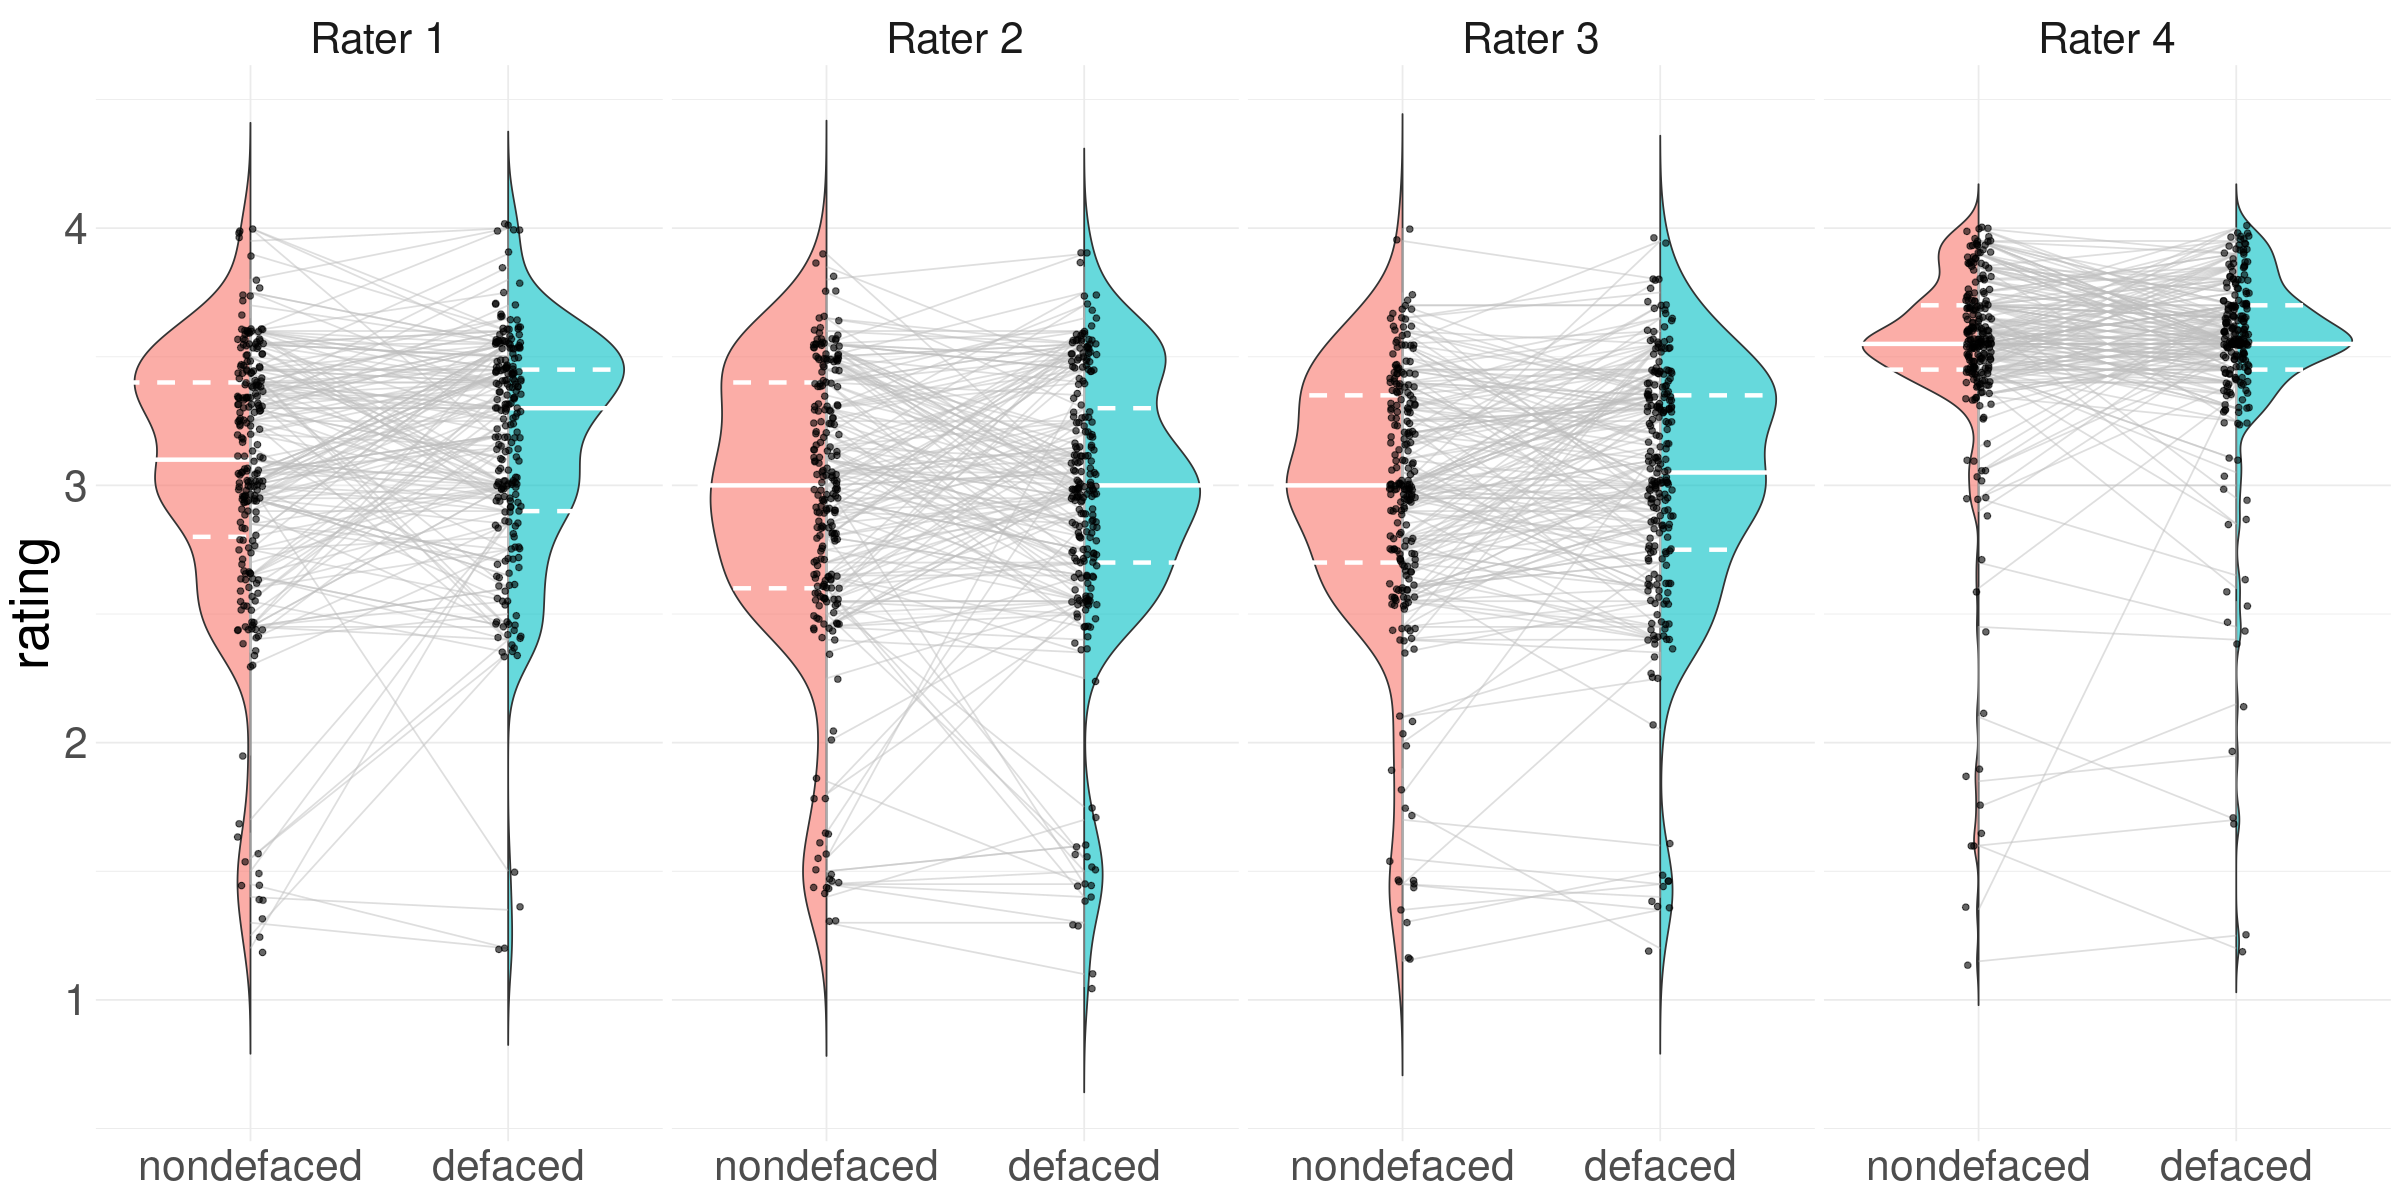

In [6]:
# Plot
p <- ggplot(df, aes(x = is_defaced, y = rating, group = is_defaced)) +
  geom_violinhalf(aes(fill = is_defaced), trim = FALSE, scale = "width", alpha = 0.6, flip = c(0, 1)) +
  stat_summary(fun = quantile, fun.args = list(probs = c(0.5)), geom = "crossbar", width = 1, color = "white") +
  stat_summary(fun = quantile, fun.args = list(probs = c(0.25, 0.75)), geom = "crossbar", width = 1, color = "white", linetype = "dashed") +
  geom_line(aes(group = subject), color = 'gray', alpha = 0.5) +
  geom_point(position = position_jitter(width = 0.05), alpha = 0.6) +
  theme_minimal() +
  theme(text = element_text(size = 32)) +
  theme(legend.position = "none") +
  theme(axis.title.x = element_blank()) +
  facet_wrap(~ rater_label, ncol = 4)

# Visualize
height <- 10
width <- 20

# Set a new figure size for BA plots
options(repr.plot.width = width, repr.plot.height = height)

ggsave(file = "../../outputs/ManualRatings/figure3.tif", width = width, height = height, plot = p, dpi = 320, bg="white")
ggsave(file = "../../outputs/ManualRatings/figure3.svg", width = width, height = height, plot = p, dpi = 320, bg="white")
# ggsave(file = "../../outputs/ManualRatings/figure3.eps", width = width, height = height, plot = p, dpi = 320, bg="white")
ggsave(file = "../../outputs/ManualRatings/figure3.png", width = width, height = height, plot = p, dpi = 320, bg="white")

print(p)

## Bland-Altman plot

### Prepare the dataset

We have some massaging to do so that the data table is acceptable by our plotting function

In [7]:
# Step (i): Create a copy where x is nondefaced and y is defaced (scatter plot)
df_timepoint_0 <- df_wide_ba %>%
  mutate(
    x = nondefaced,
    y = defaced,
    timepoint = 0,
  )

# Step (ii): Create a copy where x is (defaced + defaced) / 2 and timepoint is 0
df_timepoint_1 <- df_wide_ba %>%
  mutate(
    x = mean,
    y = deltas,
    timepoint = 1
  )

# Step (iii): Create a copy where x is nondefaced and timepoint is 1
df_timepoint_2 <- df_wide_ba %>%
  mutate(
    x = nondefaced,
    y = deltas,
    timepoint = 2
  )

# Step (iv): Duplicate ii
df_timepoint_3 <- df_wide_ba %>%
  mutate(
    x = mean,
    y = deltas,
    timepoint = 3
  )

# Step (iv): Concatenate both tables
df_ba <- bind_rows(df_timepoint_0, df_timepoint_1, df_timepoint_2, df_timepoint_3)

# Print data types of all columns to see if we have lists
sapply(df_ba, class)

# # Remove rows with NA or NaN values in numeric columns (x, rating, timepoint)
# df_wide_ba <- df_wide_ba %>%
#   filter(!is.na(x), !is.na(deltas), !is.na(timepoint)) %>%
#   filter(!is.nan(x), !is.nan(deltas))
df_ba_selected <- df_ba %>% select(x, y, timepoint, deltas, rater_id)
df_ba_selected <- df_ba_selected %>%
  mutate(timepoint = as.integer(timepoint))

nrow(df_ba_selected)

rater_id     subject rater_label     defaced  nondefaced        mean 
"character"   "integer" "character"   "numeric"   "numeric"   "numeric" 
     deltas           x           y   timepoint 
  "numeric"   "numeric"   "numeric"   "numeric"

[1] 3600

### Programmatic creation of cool BA plots
We first implement the plotting function. We also prepare some colors.

In [8]:
# Helper function to generate BA plot
ba_plot_defacing <- function(
  data,
  title,
  rater,
  point_size = 2.5,
  color_1 = "#F5C241",
  color_2 = "#643296",
  color_12 = "#EDDAAA",
  color_22 = "#A695B8",
  line_color = "grey",
  color_reliable = "grey",
  yaxis = "deltas",
  mode = "optimized",
  dynamic = FALSE) {

  # Filter out dataset
  tmap <- c("traditional" = 1, "optimized" = 2, "scatter" = 0)

  if (!dynamic) {
    data <- data %>% filter(timepoint == tmap[mode])
  }

  mean_diff <- mean(data$deltas, na.rm = TRUE)
  sd_diff <- sd(data$deltas, na.rm = TRUE)
  ci_diff <- 1.96 * (sd_diff / sqrt(nrow(data)))
  la_diff <- 2.0 * sd_diff

  la_inf <- mean_diff - la_diff
  la_sup <- mean_diff + la_diff

  bias_label_x <- 2.5
  bias_label_y <- 2.2
  bias_label_size <- 8
  bias_label_hjust <- 0.5

  # Create color categories
  data <- data %>% mutate(
    color = case_when(
      deltas <= la_inf ~ color_2,
      deltas >= la_sup ~ color_1,
      deltas > 0.0 ~ color_12,
      deltas < -0.0 ~ color_22,
      TRUE ~ color_reliable
    )
  )

  rater_data_df <- data

  df_bias <- data %>%
    group_by(rater_id) %>%
    summarise(
      mean_diff = mean(deltas, na.rm = TRUE),  # Compute bias for each rater
      sd_diff = sd(deltas, na.rm = TRUE),      # Compute SD
      ci_diff = 1.96 * (sd_diff / sqrt(n())),  # Compute 95% CI
      .groups = "drop"
    )


  x_labels <- c(
    "0" = "**nondefaced** rating",
    "1" = "**average** rating",
    "2" = "**nondefaced** rating",
    "3" = "**average** rating"
  )

  y_labels <- c(
    "0" = "**defaced** rating",
    "1" = "ratings **difference** (Δ<sub>ndef-def</sub>)",
    "2" = "ratings **difference** (Δ<sub>ndef-def</sub>)",
    "3" = "ratings **difference** (Δ<sub>ndef-def</sub>)"
  )

  # Configure aesthetic mappings (aes)
  if (mode != "transition") {
    xlabel <- x_labels[as.character(tmap[mode])]
    ylabel <- y_labels[as.character(tmap[mode])]
  } else {
    xlabel <- ""
    ylabel <- y_labels["1"]
  }

  if (missing(rater)) {
    if (mode == "transition") {
      data <- data %>% filter(timepoint > 0)
    } else {
      data <- data %>% filter(timepoint == tmap[mode])
    }

    # Plot the "All raters" scatter or BA
    ba <- ggplot(data = data, aes(x = x, y = y)) +
      geom_point(size = point_size + 1, aes(color = color)) +
      xlab(xlabel) +
      ylab(ylabel) +
      theme(
        axis.title.x = element_markdown(size = 22),
        axis.title.y = element_markdown(size = 22),
        axis.text = element_text(size = 16),
        axis.ticks = element_line(linewidth = 0),
      ) +
      scale_x_continuous(
        breaks = c(1.25, 2, 3, 3.75),
        labels = c("exclude", "poor", "acceptable", "excellent"),
        limits = c(0.9, 4.1)
      )

    if (mode != "scatter") {
      ba <- ba +
        ylim(-2.2, 2.2) +
        annotation_custom(
          grobTree(
            richtext_grob(
              "defaced<br /><b>lower</b>",
              x = 0.08,
              y = 0.80,
              hjust = 0,
              vjust = 1,
              gp = gpar(fontsize = 23, col = color_1, lineheight = 0.8)
            )
          )
        ) +
        annotation_custom(
          grobTree(
            richtext_grob(
              "defaced<br /><b>higher</b>",
              x = 0.92,
              y = 0.20,
              hjust = 1,
              vjust = 0,
              gp = gpar(fontsize = 23, col = color_2, lineheight = 0.8)
            )
          )
        )
    } else {
      ba <- ba +
        scale_y_continuous(
          breaks = c(1.25, 2, 3, 3.75),
          labels = c("exclude", "poor", "acceptable", "excellent"),
          limits = c(0.9, 4.1)
        ) +
        theme(
          axis.text.y=element_text(angle = 90, hjust = 0.5, vjust = 1)
        )
    }
  } else {
    rater_data_df <- data %>% filter(rater_id == rater)

    mean_diff <- mean(rater_data_df$deltas, na.rm = TRUE)
    sd_diff <- sd(rater_data_df$deltas, na.rm = TRUE)
    ci_diff <- 1.96 * (sd_diff / sqrt(nrow(rater_data_df)))
    la_diff <- 2.0 * sd_diff

    la_inf <- mean_diff - la_diff
    la_sup <- mean_diff + la_diff

    # bias_label_x = 4.1
    # bias_label_y = 1.96
    bias_label_size <- 6
    # bias_label_hjust = 1

    rater_data_df <- rater_data_df %>% mutate(
      color = case_when(
        deltas < la_inf ~ color_2,
        deltas > la_sup ~ color_1,
        deltas > 0.0 ~ color_12,
        deltas < -0.0 ~ color_22,
        TRUE ~ color_reliable
      )
    )

    # Plot only this rater's dataset
    ba <- ggplot(
      rater_data_df,
      aes(x = x, y = y),
    ) +
      geom_point(
        data = data,
        aes(x = x, y = y),
        color = "#d9d9d9",
        size = point_size - 0.5) +
      geom_point(size = point_size, aes(color = color)) +
      xlab("") +
      ylab("") +
      theme(
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
      ) +
      xlim(0.9, 4.1) +
      coord_fixed()

    if (mode == "scatter") {
      ba <- ba +
        ylim(0.9, 4.1)
    }
  }

  ###
  ### At this point 'ba' contains the plot
  ###
  ba <- ba +
    scale_color_identity() +
    theme(legend.position = "none") +
    theme(panel.background = element_blank())

  if (mode != "scatter") {
    # Bias annotation
    bias_color = "gray"
    bias_text = "black"
    if (mean_diff + ci_diff < 0) {
      bias_color = "black"
      bias_text = "white"
    }
    bias_annotation <- ggtext::geom_richtext(
      data = data.frame(
        x = 2.5,
        y = mean_diff,
        label = paste0(
          sprintf("%.2f", mean_diff),
          " \u00B1 ",  # Unicode for ±
          sprintf("%.3f", ci_diff)
        )
      ),
      aes(x = x, y = y, label = label),
      fill = bias_color,  # Background color matching the line
      color = bias_text,  # Text color for contrast
      label.color = NA,  # Remove border
      size = bias_label_size - 0.75,
      hjust = 0.5,  # Left-align text
      vjust = 0.5  # Center vertically
    )

    # LoA annotation
    loa_annotation_upper <- ggtext::geom_richtext(
      data = data.frame(
        x = 1.2,
        y = la_sup,
        label = sprintf("%.2f", la_sup)
      ),
      aes(x = x, y = y, label = label),
      fill = color_1,  # Background color matching the line
      color = "black",  # Text color for contrast
      label.color = NA,  # Remove border
      size = bias_label_size,
      hjust = 1,
      vjust = 0.5  # Center vertically
    )

    loa_annotation_lower <- ggtext::geom_richtext(
      data = data.frame(
        x = 3.8,
        y = la_inf,
        label = sprintf("%.2f", la_inf)
      ),
      aes(x = x, y = y, label = label),
      fill = color_2,  # Background color matching the line
      color = "white",  # White text for contrast
      label.color = NA,  # Remove border
      size = bias_label_size,
      hjust = 0,  # Left-align text
      vjust = 0.5  # Center vertically
    )

    ba <- ba +
      geom_hline(
        yintercept = 0,
        color = "#7f7f7f",
        linetype = "solid",
        linewidth = 0.5
      ) +
      geom_hline(
        yintercept = la_sup,
        color = color_1,
        linetype = "dashed",
        linewidth = 0.5,
        alpha = 0.6
      ) +
      geom_hline(
        yintercept = la_inf,
        color = color_2,
        linetype = "dashed",
        linewidth = 0.5,
        alpha = 0.6
      ) +
      geom_hline(
        yintercept = mean_diff,
        linetype = "dashed",
        color = bias_color,
        linewidth = 1,
        aes(linetype = "bias")
      ) +  # Bias line
      bias_annotation +
      # loa_annotation
      loa_annotation_upper +
      loa_annotation_lower
  } else {
    ba <- ba + geom_segment(
      aes(x = 1, y = 1, xend = 4.05, yend = 4.05),
      linetype = "dashed",
      color = color_reliable
    ) +
    coord_fixed(clip = "off")
  }

  if (mode == "transition") {
    ba <- ba +
      transition_states(
        timepoint,
        transition_length = 2,
        state_length = 1,
        wrap = FALSE
      ) +
      labs(
        x = "{x_labels[as.character(closest_state)]}"
      ) +
      ease_aes("cubic-in-out")
  }
  #  else {
  #   ba <- ba +
  #     coord_fixed()
  # }

  if (!missing(title)) {
    ba <- ba +
      ggtitle(
        title,
        subtitle = paste0("n = ", nrow(rater_data_df))
      ) +
      theme(
        plot.title = element_text(
          face = 2,
          size = if (missing(rater)) 28 else 24,
          hjust = if (mode == "scatter") 0.5 else 1,
        ),
        plot.subtitle = element_text(
          face = 1,
          size = if (missing(rater)) 20 else 16,
          hjust = if (mode == "scatter") 0.5 else 1,
        ),
      )
  }

  # ba <- ba + coord_cartesian(clip = "off")
  return(ba)
}

generate_legend <- function(
  color_1 = "#F5C241",
  color_2 = "#643296",
  color_12 = "#EDDAAA",
  color_22 = "#A695B8") {

  # Create the legend-like dataset
  legend_data <- data.frame(
    x = c(0.0, 0.07, 1.0, 1.07),  # Left pair and right pair (shifted slightly apart)
    y = c(1, 1, 1, 1),  # All points are on the same row
    category = factor(c("Beyond", "Beyond", "Within", "Within")),
    color = c(color_1, color_2, color_12, color_22)  # Assign correct colors
  )

  # Create the "legend plot"
  legend_plot <- ggplot(legend_data, aes(x = x, y = y, color = color)) +
    geom_point(size = 8) +  # Ensure dots are clear
    scale_color_identity() +  # Use color as defined in the dataset
    annotate("text", x = 0.15, y = 1, label = "Outside 95% LoA", hjust = 0, size = 8) +  # Left label
    annotate("text", x = 1.15, y = 1, label = "Within 95% LoA", hjust = 0, size = 8) +  # Right label
    # LoA lines
    geom_segment(aes(x = 2.0, xend = 2.11, y = 1.0002, yend = 1.0002), linetype = "dashed", color = color_1, linewidth = 0.8) +
    geom_segment(aes(x = 2.0, xend = 2.11, y = 0.9998, yend = 0.9998), linetype = "dashed", color = color_2, linewidth = 0.8) +
    annotate("text", x = 2.15, y = 1, label = "95% LoA", hjust = 0, size = 8) +
    # Add Bias dashed line
    geom_segment(aes(x = 3.0, xend = 3.11, y = 1, yend = 1), linetype = "dashed", color = "black", linewidth = 1.2) +
    ggtext::geom_richtext(aes(x = 3.15, y = 1, label = "**𝔼**[Δ<sub>ndef-def</sub>] (bias)"),
                          hjust = 0, vjust = 0.65, size = 8, fill = NA, label.color = NA, color = "black") +
    # Keep limits tight
    xlim(0.0, 4) +  # Keep x-axis tight to relevant data
    ylim(0.999, 1.001) +  # Keep y-axis tight
    theme_void()  # Remove axes, grid, etc.

  return(legend_plot)
}

### Scatter plot (nondefaced vs defaced)

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Warning message in geom_segment(aes(x = 1, y = 1, xend = 4.05, yend = 4.05), linetype = "dashed", :
“All aesthetics have length 1, but the data has 900 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”
Warning message in geom_segment(aes(x = 1, y = 1, xend = 4.05, yend = 4.05), linetype = "dashed", :
“All aesthetics have length 1, but the data has 225 rows.
ℹ Please consider using `annotate()` or provide this layer with data containi

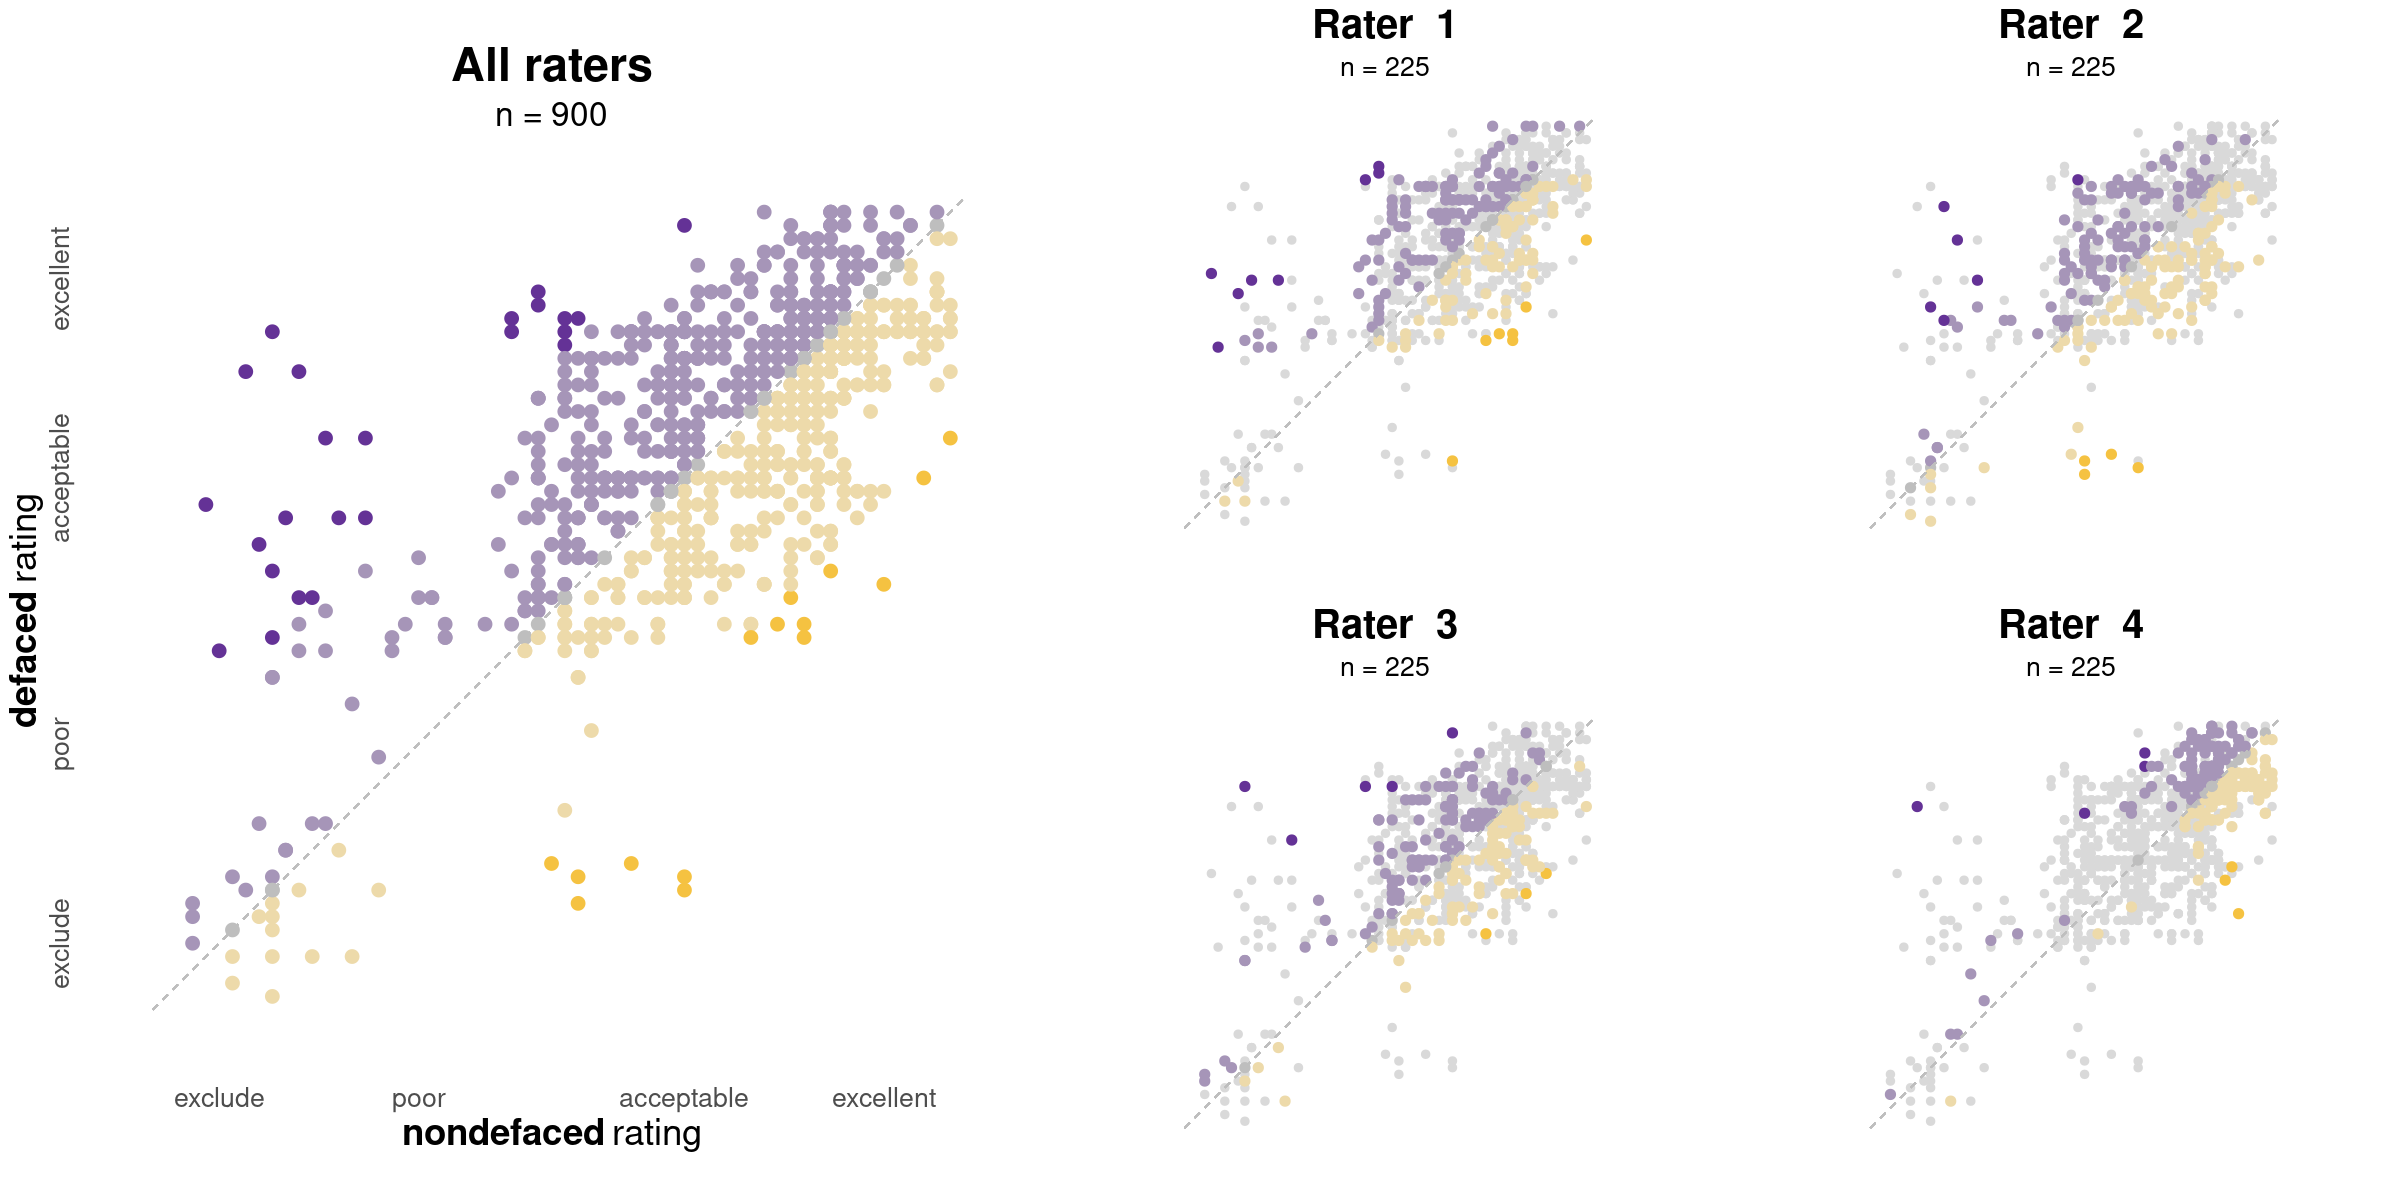

In [9]:
BA_MODE <- "scatter"

## BA plot with all raters
ba_all <- ba_plot_defacing(data = df_ba_selected, title = "All raters", mode = BA_MODE)
ba_all <- ba_all  +
  coord_fixed()

plot_list <- c(list(ba_all))

## BA for each rater
for (rater in sort(unique(df$rater_id))) {
  rater_title = paste("Rater ", strsplit(rater, "_0")[[1]][[2]])
  ba  <- ba_plot_defacing(data = df_ba_selected, title = rater_title, rater = rater, mode = BA_MODE)
  plot_list <- c(plot_list, list(ba))
}

## Combine all plots

lay <- rbind(c(1,1,1,2,2,3,3),
             c(1,1,1,4,4,5,5))
final_plot <- grid.arrange(
  grobs = plot_list,
  layout_matrix = lay,
)

height <- 10
width <- 20

# Set a new figure size for BA plots
options(repr.plot.width = width, repr.plot.height = height)
ggsave(file = "../../outputs/ManualRatings/S4_figure.svg", width = width, height = height, plot = final_plot, dpi = 320, bg="white")
ggsave(file = "../../outputs/ManualRatings/S4_figure.tif", width = width, height = height, plot = final_plot, dpi = 320, bg="white")
# ggsave(file = "../../outputs/ManualRatings/S4_figure.pdf", width = width, height = height, plot = final_plot, dpi = 320, bg="white")

### 'Traditional' and 'Optimized' Bland-Altman plots

Let's plot both types together by switching the `BA_MODE` variable

#### First the traditional version

Warning message:
“`geom_hline()`: Ignoring `mapping` because `yintercept` was provided.”
Warning message:
“`geom_hline()`: Ignoring `mapping` because `yintercept` was provided.”
Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Warning message:
“`geom_hline()`: Ignoring `mapping` because `yintercept` was provided.”
Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Warning message:
“`geom_hline()`: Ignoring `mapping` because `yintercept` was provided.”
Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Warning message:
“`geom_hline()`: Ignoring `mapping` because `yintercept` was provided.”
Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


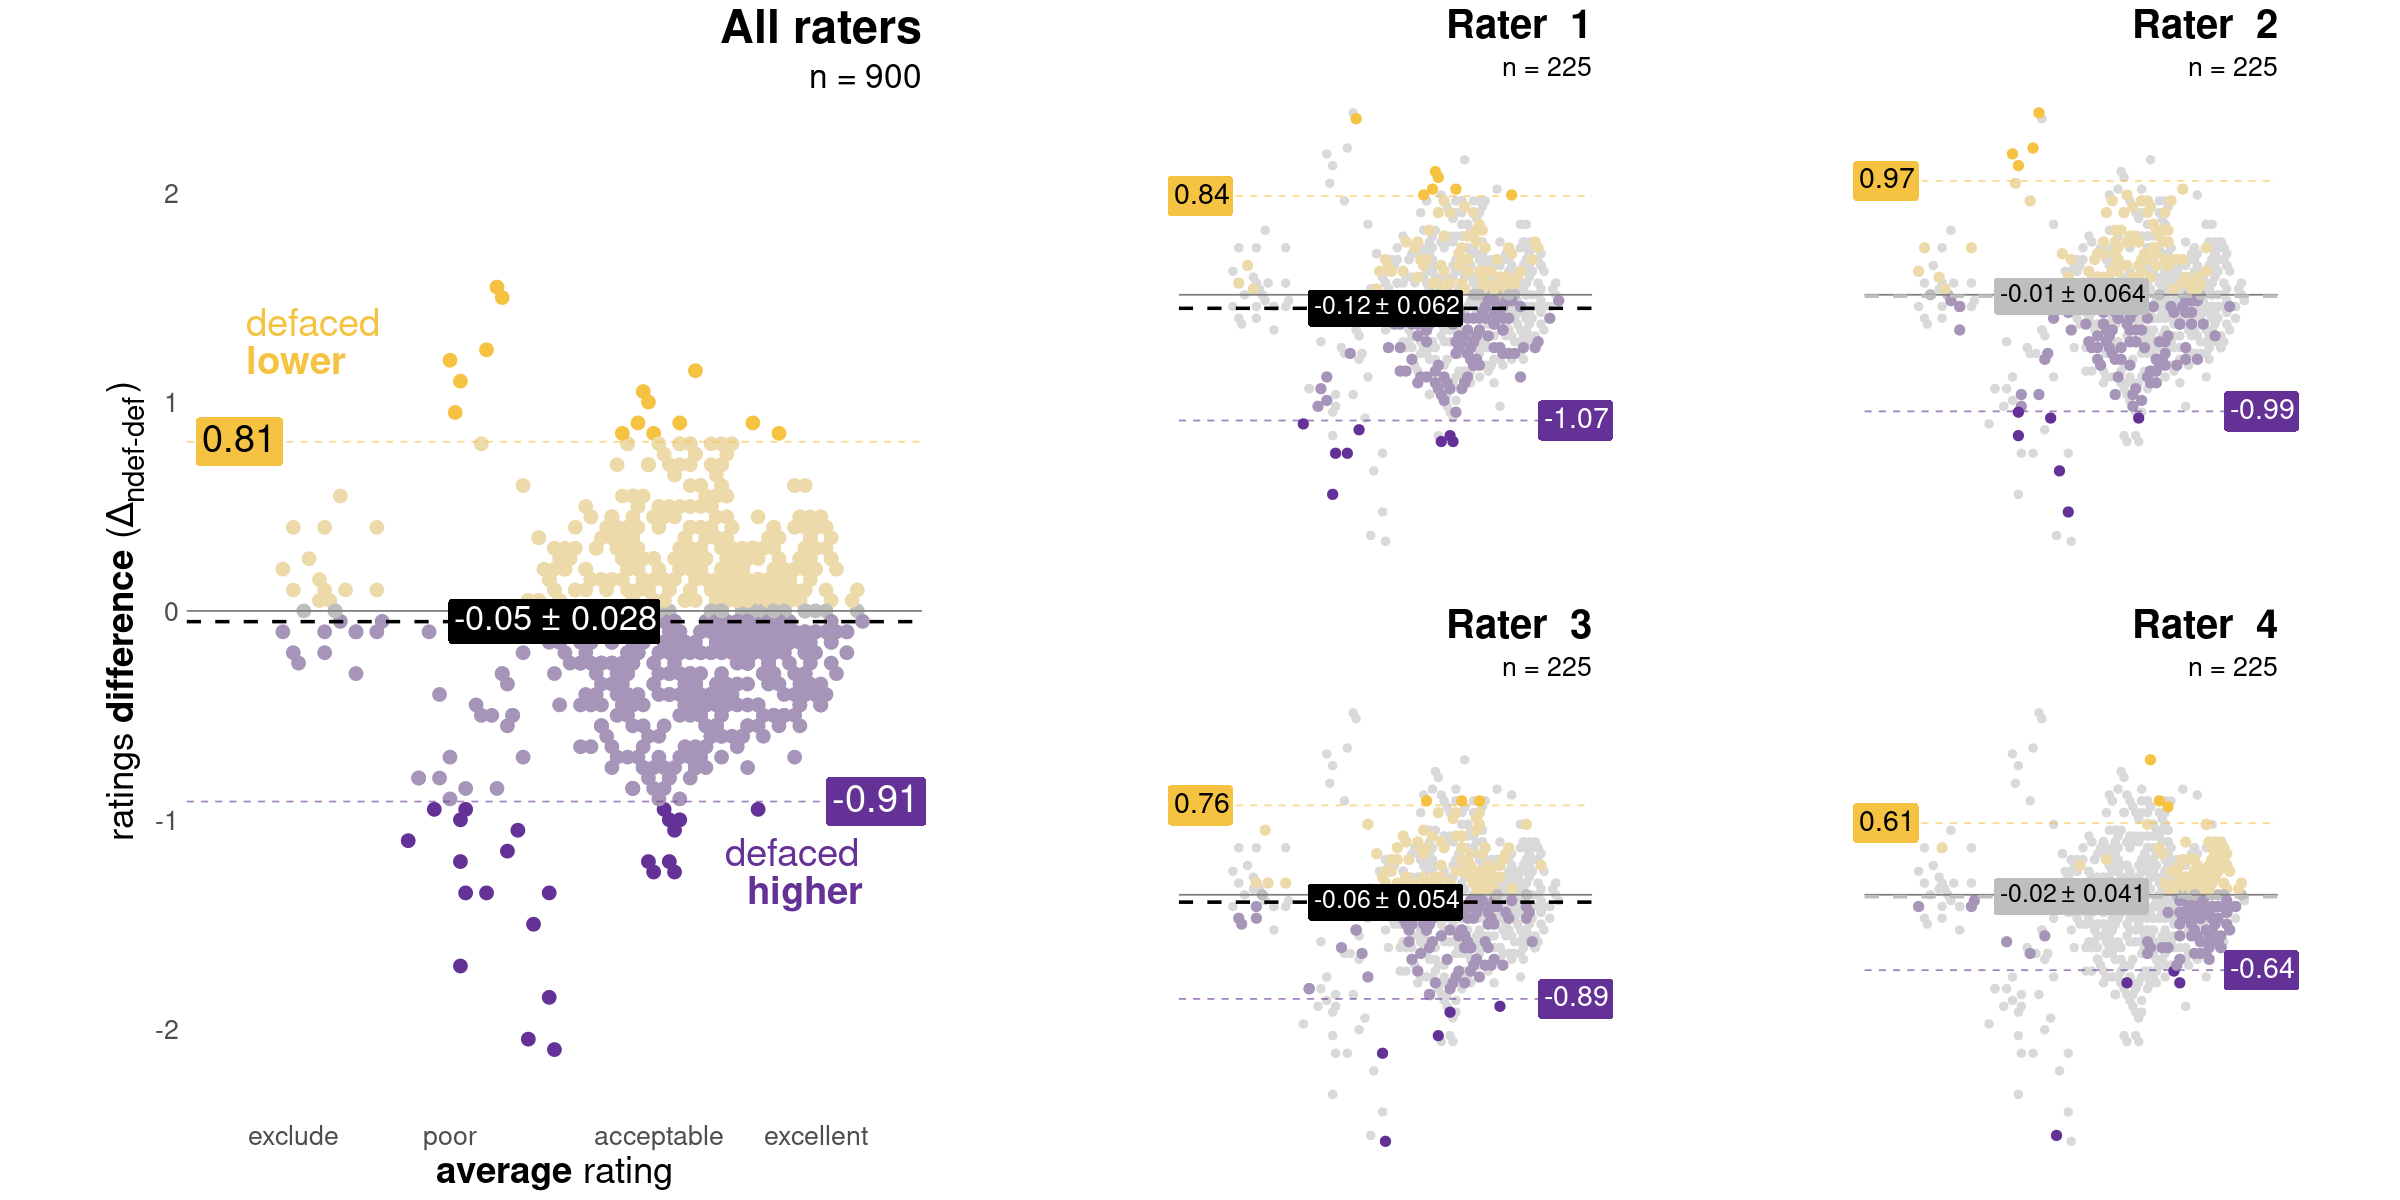

In [10]:
BA_MODE <- "traditional"

## BA plot with all raters
ba_all <- ba_plot_defacing(data = df_ba_selected, title = "All raters", mode = BA_MODE)
ba_all <- ba_all  +
  coord_fixed(clip = "off")
  
plot_list <- list()
plot_list <- c(list(ba_all), plot_list)

## BA for each rater
for (rater in sort(unique(df$rater_id))) {
  rater_title = paste("Rater ", strsplit(rater, "_0")[[1]][[2]])
  ba  <- ba_plot_defacing(data = df_ba_selected, title = rater_title, rater = rater, mode = BA_MODE)
  ba <- ba + coord_fixed(clip = "off")
  plot_list <- c(plot_list, list(ba))
}

## Combine all plots

lay <- rbind(c(1,1,1,2,2,3,3),
             c(1,1,1,4,4,5,5))
final_plot <- grid.arrange(
  grobs = plot_list,
  layout_matrix = lay,
)

height <- 11
width <- 20

# Set a new figure size for BA plots
options(repr.plot.width = width, repr.plot.height = height)
ggsave(file = "../../outputs/ManualRatings/S2_figure.svg", width = width, height = height, plot = final_plot, dpi = 320, bg="white")
ggsave(file = "../../outputs/ManualRatings/S2_figure.tif", width = width, height = height, plot = final_plot, dpi = 320, bg="white")
# ggsave(file = "../../outputs/ManualRatings/figureS2.pdf", width = width, height = height, plot = final_plot, dpi = 320, bg="white")

#### 'Optimized' Bland-Altman plots

Warning message:
“`geom_hline()`: Ignoring `mapping` because `yintercept` was provided.”
Warning message:
“`geom_hline()`: Ignoring `mapping` because `yintercept` was provided.”
Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Warning message:
“`geom_hline()`: Ignoring `mapping` because `yintercept` was provided.”
Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Warning message:
“`geom_hline()`: Ignoring `mapping` because `yintercept` was provided.”
Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Warning message:
“`geom_hline()`: Ignoring `mapping` because `yintercept` was provided.”
Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Warning message in geom_segment(aes(x = 2, xend = 2.11, y = 1.0002, yend = 1.0002), :
“All aesthetics have length 1, but the data has 4 rows.
ℹ Ple

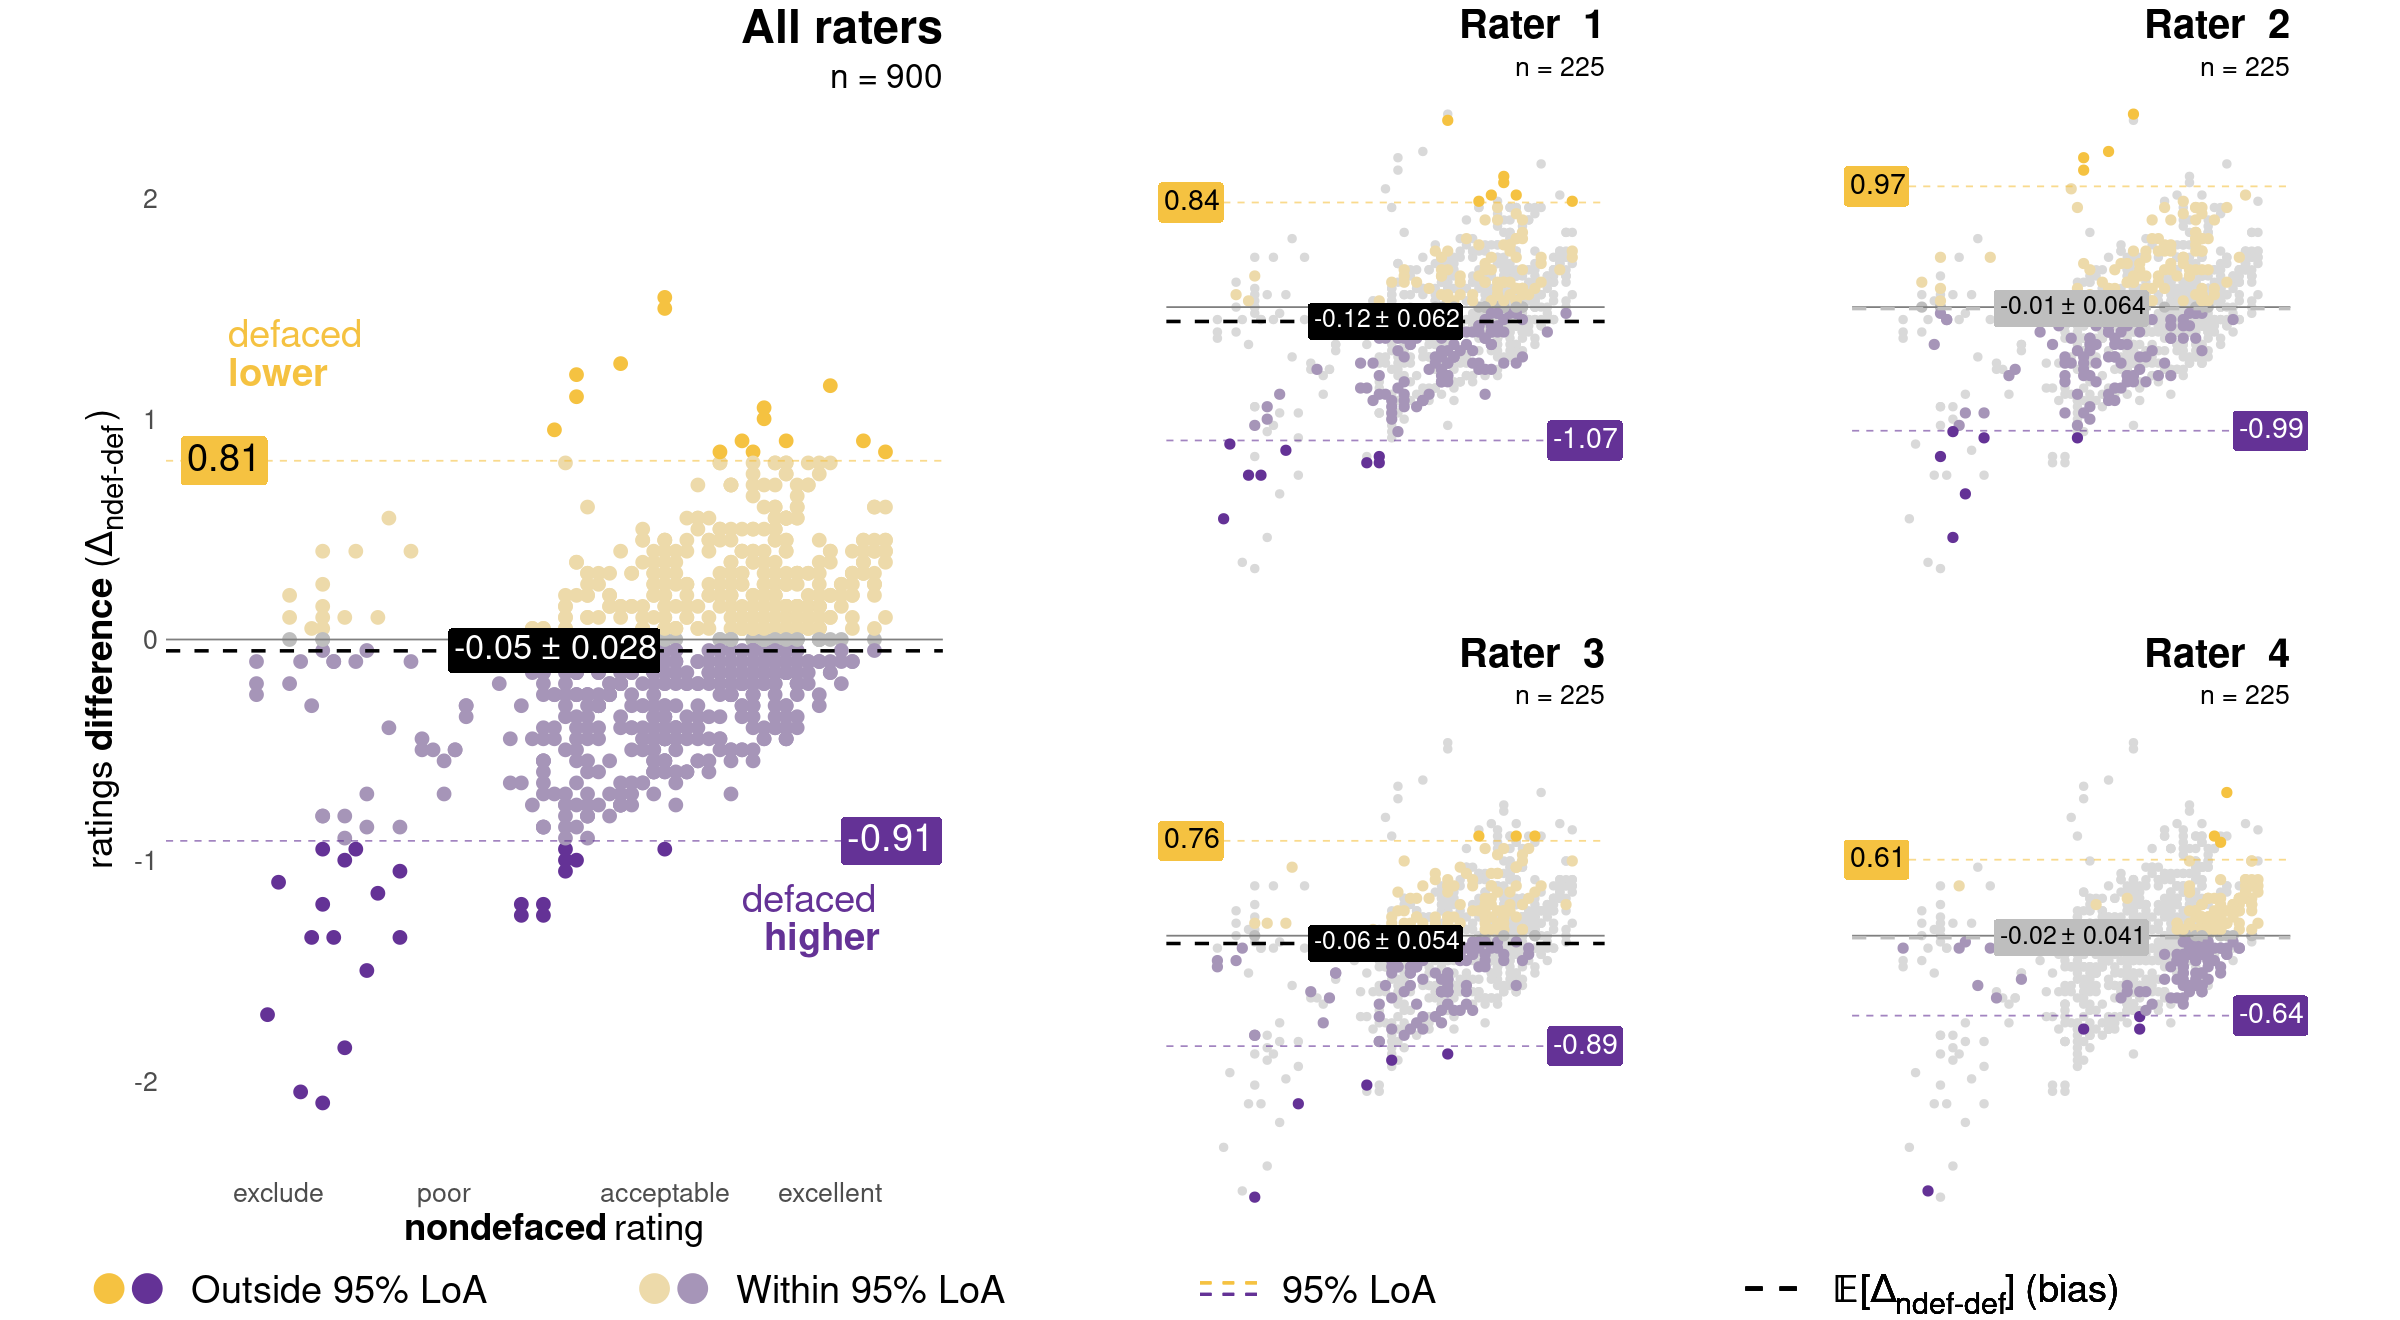

In [11]:
BA_MODE <- "optimized"

plot_list <- list()

point_size <- 2.5

## BA plot with all raters
ba_all <- ba_plot_defacing(data = df_ba_selected, title = "All raters", mode = BA_MODE)
ba_all <- ba_all  +
  coord_fixed(clip = "off")

plot_list <- c(list(ba_all), plot_list)

## BA for each rater
for (rater in sort(unique(df$rater_id))) {
  rater_title = paste("Rater ", strsplit(rater, "_0")[[1]][[2]])
  ba  <- ba_plot_defacing(data = df_ba_selected, title = rater_title, rater = rater, mode = BA_MODE)
  ba <- ba + coord_fixed(clip = "off")
  plot_list <- c(plot_list, list(ba))
}

# Generate a plot looking like a legend
legend <- generate_legend()

## Combine all plots
final_plot <- grid.arrange(
  # grobs = plot_list,
  grobs = c(plot_list, list(legend)),
  layout_matrix = rbind(
    c(1,1,1,2,2,3,3),
    c(1,1,1,4,4,5,5),
    c(6, 6, 6, 6, 6, 6, 6)  # Add legend row
  ),
  heights = c(10, 10, 1)
)

height <- 11
width <- 20

options(repr.plot.width = width, repr.plot.height = height)
ggsave(file = "../../outputs/ManualRatings/figure2.svg", width = width, height = height, plot = final_plot, dpi = 320, bg="white")
ggsave(file = "../../outputs/ManualRatings/figure2.tif", width = width, height = height, plot = final_plot, dpi = 320, bg="white")
ggsave(file = "../../outputs/ManualRatings/figure2.png", width = width, height = height, plot = final_plot, dpi = 320, bg="white")

Warning message:
“`geom_hline()`: Ignoring `mapping` because `yintercept` was provided.”


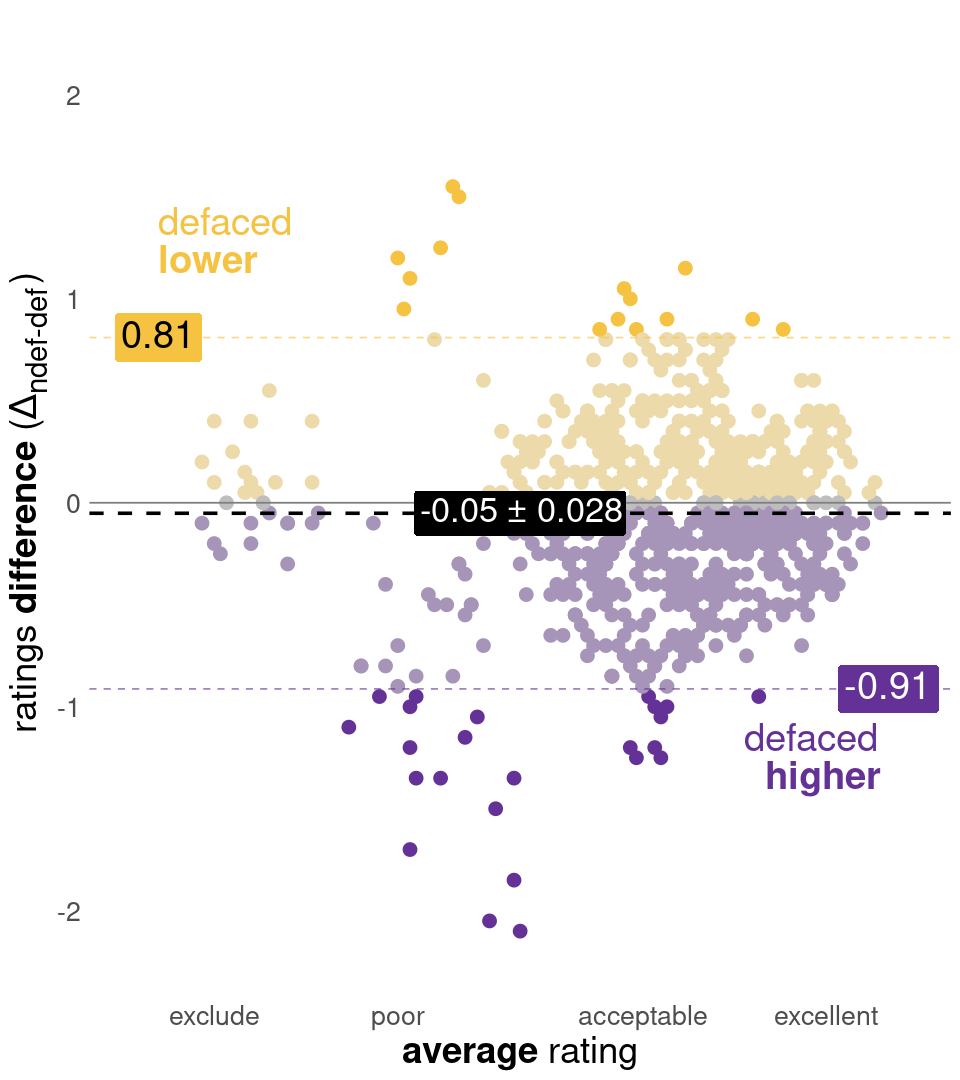

In [12]:
BA_MODE <- "traditional"

ba_all <- ba_plot_defacing(data = df_ba_selected, mode = BA_MODE)

height <- 9
width <- 8

# Set a new figure size for BA plots
options(repr.plot.width = width, repr.plot.height = height)
# ggsave(file = "../../outputs/ManualRatings/ba-traditional.svg", width = width, height = height, plot = ba_all, dpi = 200)
# ggsave(file = "../../outputs/ManualRatings/ba-traditional.pdf", width = width, height = height, plot = ba_all, dpi = 200)
# ggsave(file = "../../outputs/ManualRatings/ba-traditional.png", width = width, height = height, plot = ba_all, dpi = 200)

print(ba_all)

Warning message:
“`geom_hline()`: Ignoring `mapping` because `yintercept` was provided.”


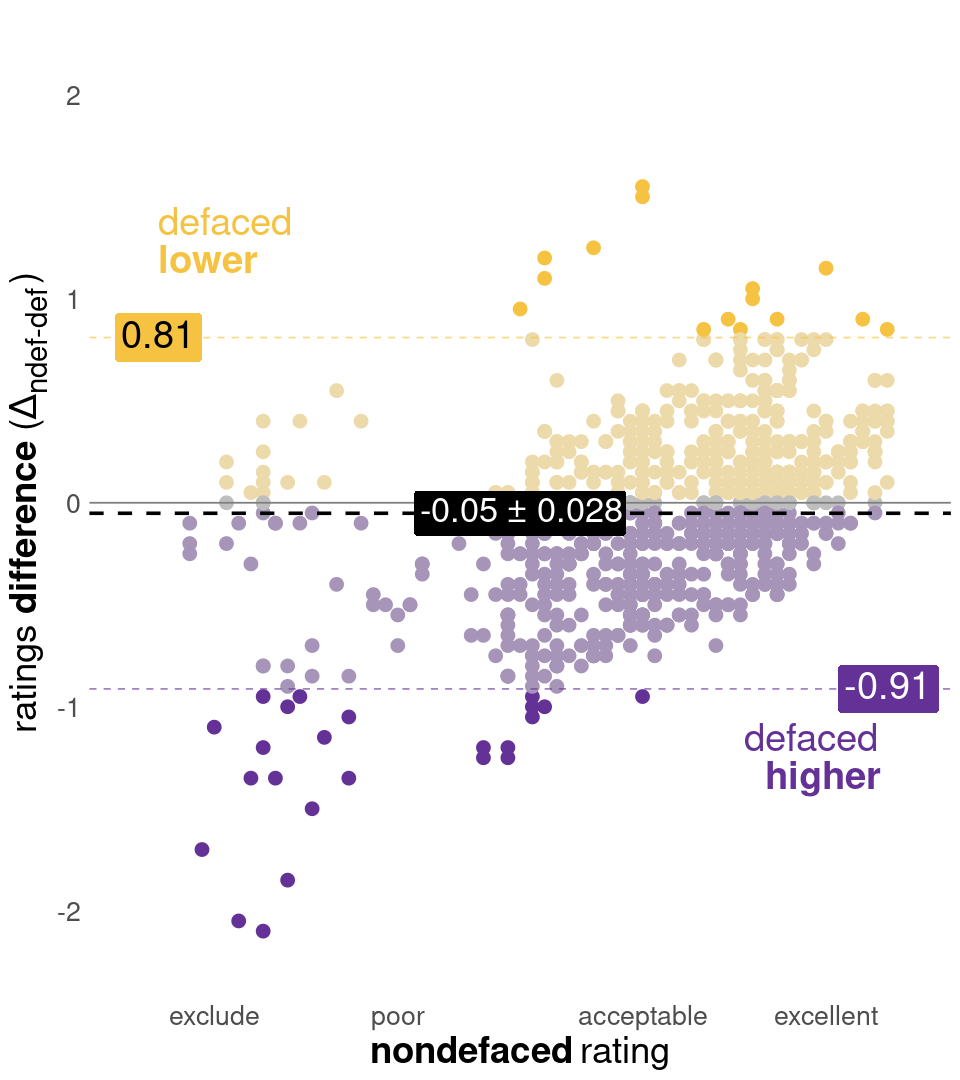

In [13]:
BA_MODE <- "optimized"

ba_all <- ba_plot_defacing(data = df_ba_selected, mode = BA_MODE)

# Set a new figure size for BA plots
options(repr.plot.width = width, repr.plot.height = height)
# ggsave(file = "../../outputs/ManualRatings/ba-optimized.svg", width = width, height = height, plot = ba_all, dpi = 200)
# ggsave(file = "../../outputs/ManualRatings/ba-optimized.pdf", width = width, height = height, plot = ba_all, dpi = 200)
# ggsave(file = "../../outputs/ManualRatings/ba-optimized.png", width = width, height = height, plot = ba_all, dpi = 200)

print(ba_all)

#### Animated version flickering between 'traditional' and 'optimized'

Let's animate this plot to highlight the transformation of the data.

In [14]:
BA_MODE <- "transition"

## BA plot with all raters
ba_all <- ba_plot_defacing(data = df_ba_selected, mode = BA_MODE, dynamic = TRUE)

animate(ba_all, width = width, height = height, units = "in", res = 200)
anim_save("../../outputs/ManualRatings/animated_plot.gif")

Warning message:
“`geom_hline()`: Ignoring `mapping` because `yintercept` was provided.”


## Investigating the biases
Given the curious observation that low ratings seem to be more biased by defacing, let us plot again the violin and line plot but with low quality and excluded images only.

[1] 132

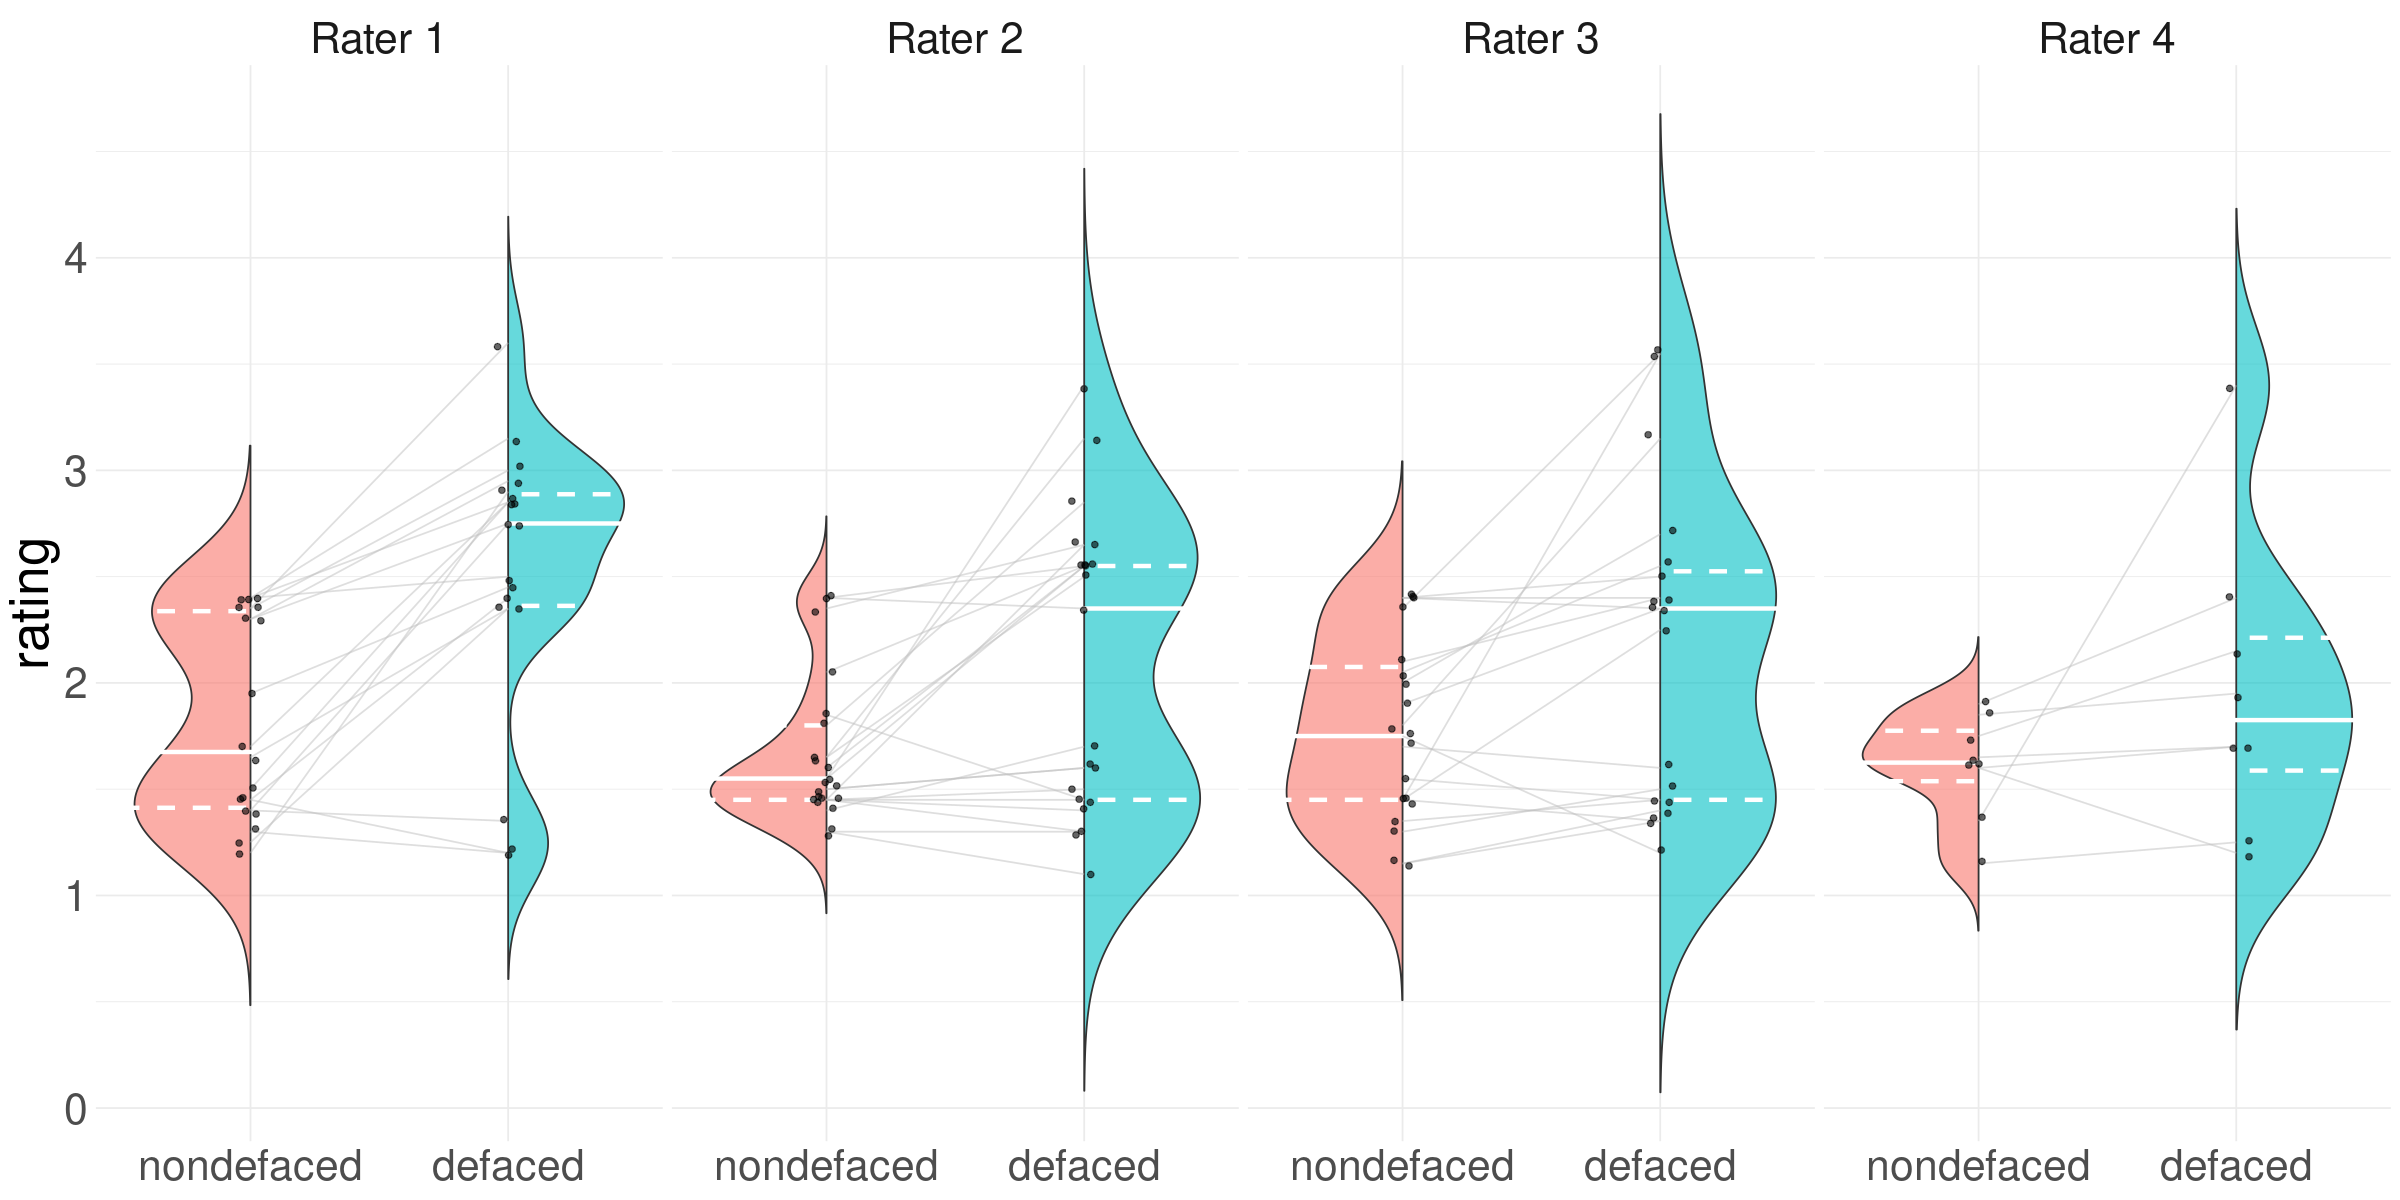

In [15]:
# Filter nondefaced ratings < 2.45 and keep their defaced counterparts
df_nodup <- df[!duplicated(df[c("subject", "is_defaced", "rater_id")]), ]
df_poor <- df_nodup %>%
  group_by(rater_id, subject) %>%
  filter(any(is_defaced == "nondefaced" & rating < 2.45)) %>%
  ungroup()
nrow(df_poor)

p <- ggplot(df_poor, aes(x = is_defaced, y = rating, group = is_defaced)) +
  geom_violinhalf(aes(fill = is_defaced), trim = FALSE, scale = "width", alpha = 0.6, flip=c(0,1)) +
  stat_summary(fun = quantile, fun.args = list(probs = c(0.5)), geom = "crossbar", width=1, color="white") +
  stat_summary(fun = quantile, fun.args = list(probs = c(0.25, 0.75)), geom = "crossbar", width=1, color="white", linetype="dashed") +
  geom_line(aes(group = subject), color = 'gray', alpha = 0.5) +
  geom_point(position = position_jitter(width = 0.05), alpha = 0.6) +
  theme_minimal() +
  theme(text = element_text(size = 32)) +
  theme(legend.position = "none") +
  theme(axis.title.x = element_blank()) +
  facet_wrap(~ rater_label, ncol = 4)

height <- 10
width <- 20

# Set a new figure size for BA plots
options(repr.plot.width = width, repr.plot.height = height)
ggsave(file = "../../outputs/ManualRatings/S3A_figure.svg", width = width, height = height, plot = p, dpi = 320, bg="white")
ggsave(file = "../../outputs/ManualRatings/S3A_figure.tif", width = width, height = height, plot = p, dpi = 320, bg="white")
# ggsave(file = "../../outputs/ManualRatings/S3A_figure.png", width = width, height = height, plot = p, dpi = 320, bg="white")

print(p)

In [16]:
for (rater in raters) {

  # Filter data for defaced=0 and defaced=1
  df_nondefaced <- df_poor %>% filter(is_defaced == "nondefaced" & rater_id == rater)
  df_defaced <- df_poor %>% filter(is_defaced == "defaced" & rater_id == rater)

  # Count unique combinations of rater_id and subject for each condition
  unique_images_nondefaced <- df_nondefaced %>% distinct(rater_id, subject)
  unique_images_defaced <- df_defaced %>% distinct(rater_id, subject)

  # Identify common image pairs between the two conditions
  common_images <- inner_join(unique_images_nondefaced, unique_images_defaced, by = c("rater_id", "subject"))

  # Output the results
  num_image_pairs <- nrow(common_images)
  num_images_nondefaced <- nrow(unique_images_nondefaced)
  num_images_defaced <- nrow(unique_images_defaced)

  print(rater)
  print(list(
    num_image_pairs = num_image_pairs,
    num_images_nondefaced = num_images_nondefaced,
    num_images_defaced = num_images_defaced
  ))
}


[1] "rater_01"
$num_image_pairs
[1] 18

$num_images_nondefaced
[1] 18

$num_images_defaced
[1] 18

[1] "rater_02"
$num_image_pairs
[1] 21

$num_images_nondefaced
[1] 21

$num_images_defaced
[1] 21

[1] "rater_03"
$num_image_pairs
[1] 19

$num_images_nondefaced
[1] 19

$num_images_defaced
[1] 19

[1] "rater_04"
$num_image_pairs
[1] 8

$num_images_nondefaced
[1] 8

$num_images_defaced
[1] 8



[1] 132

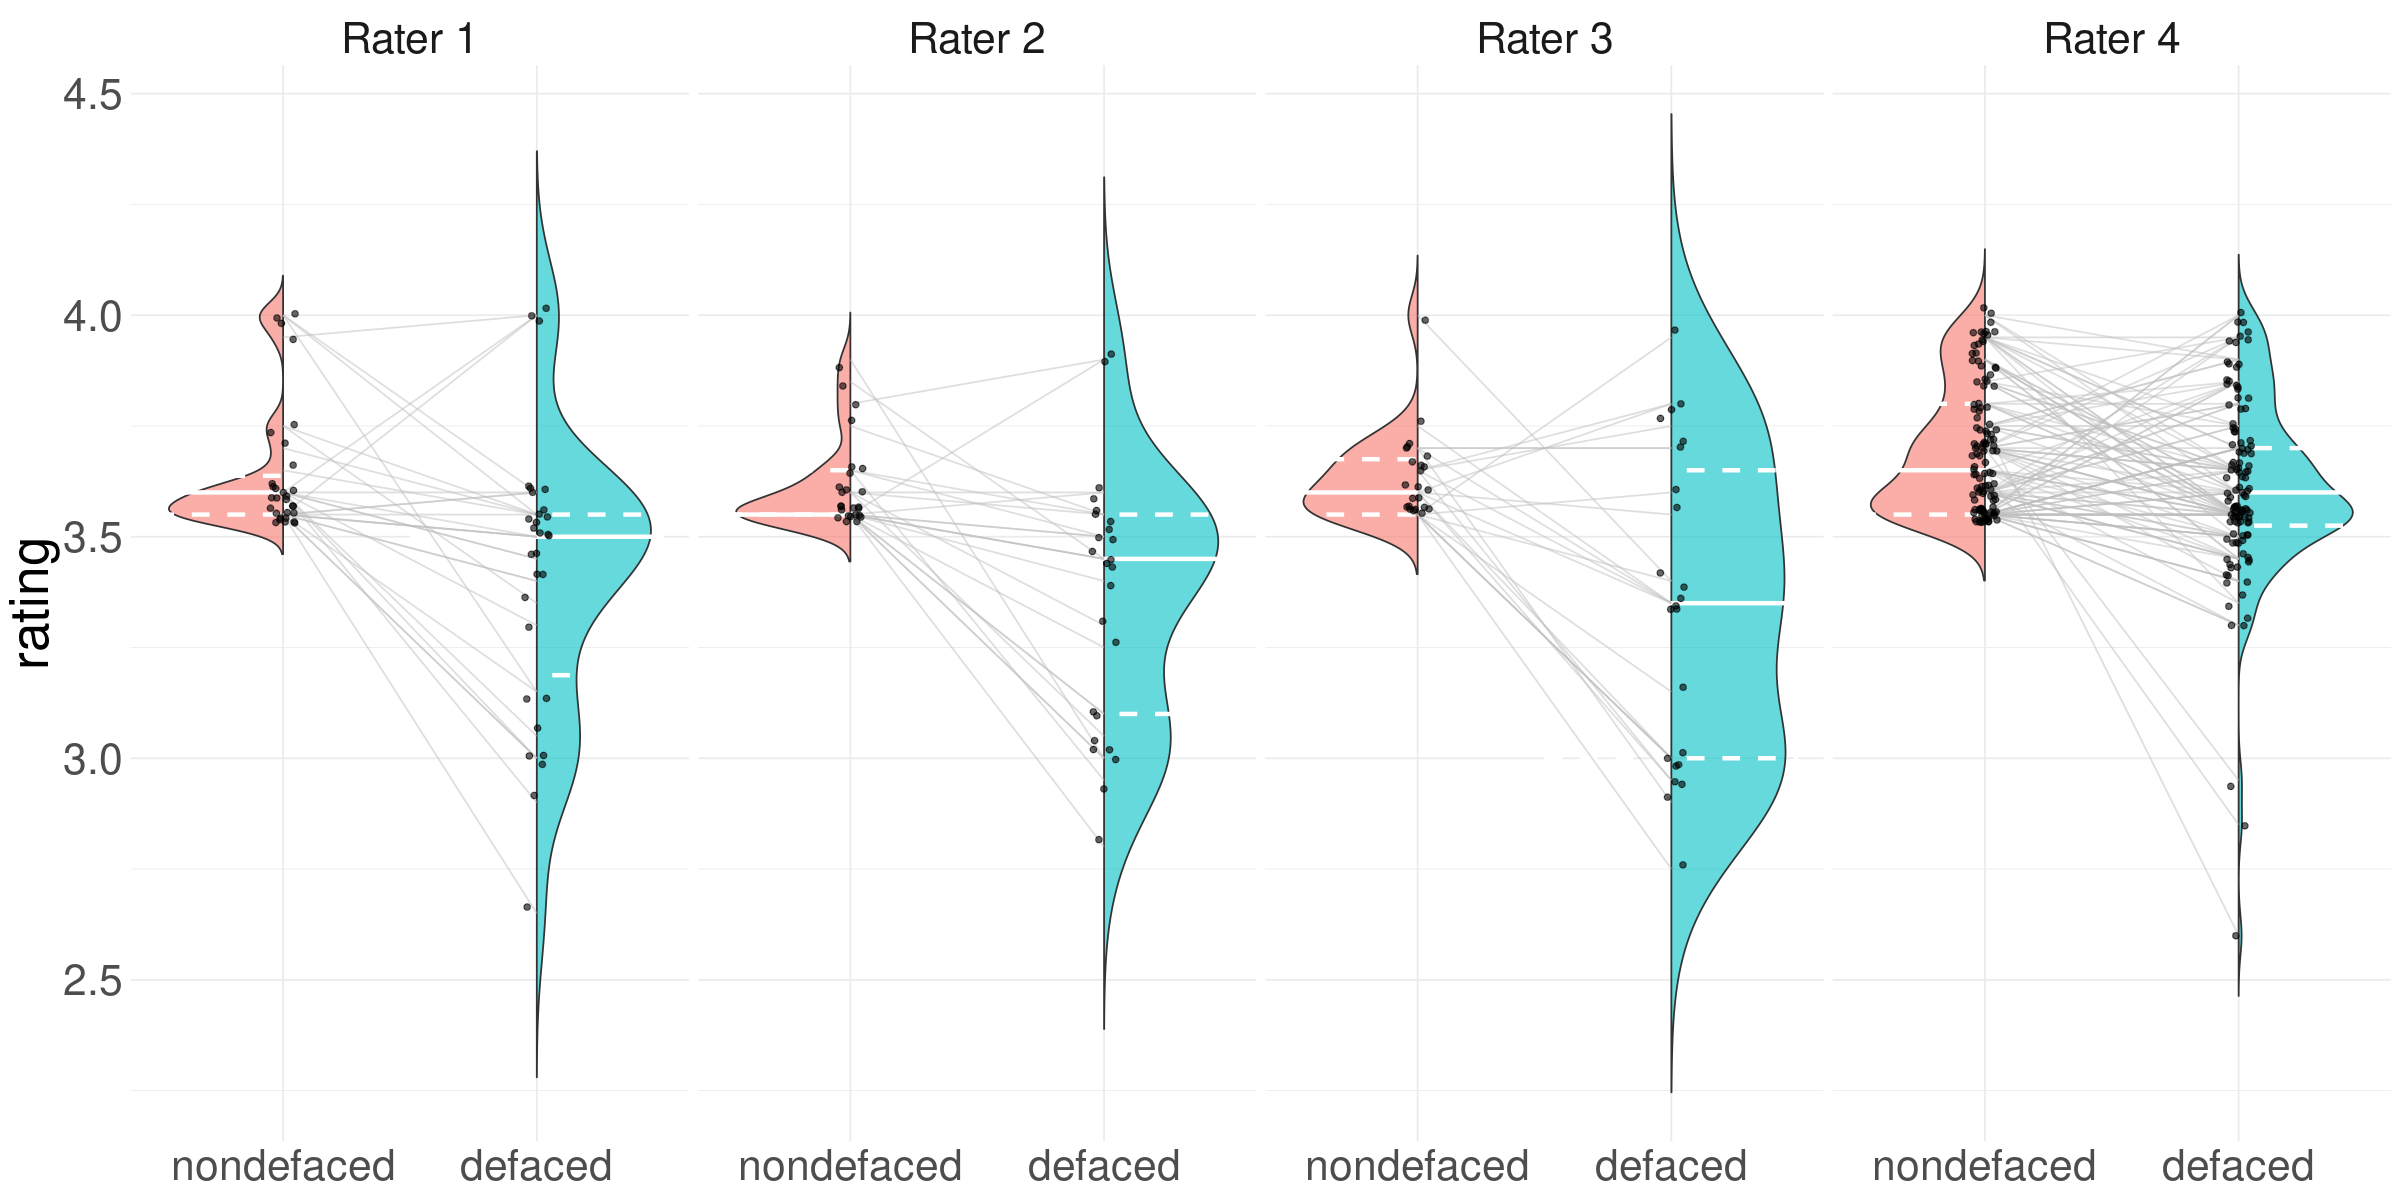

In [17]:
# Filter nondefaced ratings < 2.45 and keep their defaced counterparts
df_nodup <- df[!duplicated(df[c("subject", "is_defaced", "rater_id")]), ]
df_excel <- df_nodup %>%
  group_by(rater_id, subject) %>%
  filter(any(is_defaced == "nondefaced" & rating >= 3.55)) %>%
  ungroup()
nrow(df_poor)

p <- ggplot(df_excel, aes(x = is_defaced, y = rating, group = is_defaced)) +
  geom_violinhalf(aes(fill = is_defaced), trim = FALSE, scale = "width", alpha = 0.6, flip=c(0,1)) +
  stat_summary(fun = quantile, fun.args = list(probs = c(0.5)), geom = "crossbar", width=1, color="white") +
  stat_summary(fun = quantile, fun.args = list(probs = c(0.25, 0.75)), geom = "crossbar", width=1, color="white", linetype="dashed") +
  geom_line(aes(group = subject), color = 'gray', alpha = 0.5) +
  geom_point(position = position_jitter(width = 0.05), alpha = 0.6) +
  theme_minimal() +
  theme(text = element_text(size = 32)) +
  theme(legend.position = "none") +
  theme(axis.title.x = element_blank()) +
  facet_wrap(~ rater_label, ncol = 4)

ggsave(file = "../../outputs/ManualRatings/S3B_figure.svg", width = width, height = height, plot = p, dpi = 320, bg="white")
ggsave(file = "../../outputs/ManualRatings/S3B_figure.tif", width = width, height = height, plot = p, dpi = 320, bg="white")
ggsave(file = "../../outputs/ManualRatings/S3B_figure.png", width = width, height = height, plot = p, dpi = 320, bg="white")

print(p)

In [18]:
#Count the number of image pair for each rater
for (rater in raters) {

  # Filter data for defaced=0 and defaced=1
  df_nondefaced <- df_excel %>% filter(is_defaced == "nondefaced" & rater_id == rater)
  df_defaced <- df_excel %>% filter(is_defaced == "defaced" & rater_id == rater)

  # Count unique combinations of rater_id and subject for each condition
  unique_images_nondefaced <- df_nondefaced %>% distinct(rater_id, subject)
  unique_images_defaced <- df_defaced %>% distinct(rater_id, subject)

  # Identify common image pairs between the two conditions
  common_images <- inner_join(unique_images_nondefaced, unique_images_defaced, by = c("rater_id", "subject"))

  # Output the results
  num_image_pairs <- nrow(common_images)
  num_images_nondefaced <- nrow(unique_images_nondefaced)
  num_images_defaced <- nrow(unique_images_defaced)

  print(rater)
  print(list(
    num_image_pairs = num_image_pairs,
    num_images_nondefaced = num_images_nondefaced,
    num_images_defaced = num_images_defaced
  ))
}


[1] "rater_01"
$num_image_pairs
[1] 30

$num_images_nondefaced
[1] 30

$num_images_defaced
[1] 30

[1] "rater_02"
$num_image_pairs
[1] 25

$num_images_nondefaced
[1] 25

$num_images_defaced
[1] 25

[1] "rater_03"
$num_image_pairs
[1] 23

$num_images_nondefaced
[1] 23

$num_images_defaced
[1] 23

[1] "rater_04"
$num_image_pairs
[1] 115

$num_images_nondefaced
[1] 115

$num_images_defaced
[1] 115



# Intra-rater reliability
## Violin and line plot

In [19]:
# Identify duplicates as rows that share the same rater_id using dplyr, defaced condition and subject. Those are the 40 subjects that we presented twice in both conditions to assess the intra-rater variability.
df_intra <- df %>% group_by(rater_id, subject) %>% filter(n() > 2)

#Verify that 40 duplicated subjects are found
print(length(unique(df_intra$subject)))

#Add a column in the dataset encoding whether it is the first or the second time the image is presented to this rater 
df_intra$presentation <- ifelse(duplicated(df_intra[, c("subject", "rater_id", "is_defaced")]), "retest", "test")

df_intra$randomized_id <- NULL

nrow(df_intra)
df_intra

[1] 40


[1] 640

rater_id rating is_defaced subject rater_label presentation
1   rater_02 2.55   defaced     72     Rater 2     test        
2   rater_02 2.95   defaced    248     Rater 2     test        
3   rater_02 2.55   nondefaced 437     Rater 2     test        
4   rater_02 2.60   nondefaced 614     Rater 2     test        
5   rater_02 2.65   nondefaced 525     Rater 2     test        
6   rater_02 3.55   defaced    335     Rater 2     test        
7   rater_02 2.85   nondefaced  92     Rater 2     test        
8   rater_02 3.55   defaced    385     Rater 2     test        
9   rater_03 3.55   defaced     72     Rater 3     test        
10  rater_03 3.30   defaced    248     Rater 3     test        
11  rater_03 3.45   nondefaced 437     Rater 3     test        
12  rater_03 3.00   nondefaced 614     Rater 3     test        
13  rater_03 3.40   nondefaced 525     Rater 3     test        
14  rater_03 3.40   defaced    335     Rater 3     test        
15  rater_03 3.00   nondefaced  92     Rater 3     test        
16  rater_03 3.10   defaced    385     Rater 3     test        
17  rater_03 2.70   defaced    257     Rater 3     test        
18  rater_03 3.10   defaced    248     Rater 3     retest      
19  rater_03 3.00   defaced    385     Rater 3     retest      
20  rater_03 2.85   nondefaced 338     Rater 3     test        
21  rater_03 3.35   nondefaced 248     Rater 3     test        
22  rater_03 3.50   nondefaced 481     Rater 3     test        
23  rater_03 3.30   nondefaced  34     Rater 3     test        
24  rater_03 3.65   defaced    150     Rater 3     test        
25  rater_03 2.75   defaced    525     Rater 3     test        
26  rater_03 3.30   defaced     72     Rater 3     retest      
27  rater_03 3.30   defaced    611     Rater 3     test        
28  rater_03 3.10   defaced    610     Rater 3     test        
29  rater_03 3.75   nondefaced 522     Rater 3     test        
30  rater_03 3.05   defaced    201     Rater 3     test        
⋮   ⋮        ⋮      ⋮          ⋮       ⋮           ⋮           
611 rater_01 2.70   defaced    611     Rater 1     retest      
612 rater_01 3.60   nondefaced  51     Rater 1     retest      
613 rater_01 2.85   defaced    338     Rater 1     retest      
614 rater_01 3.20   nondefaced 572     Rater 1     retest      
615 rater_01 3.45   defaced    253     Rater 1     retest      
616 rater_01 2.90   nondefaced 385     Rater 1     retest      
617 rater_01 2.65   nondefaced  94     Rater 1     retest      
618 rater_01 3.90   nondefaced 633     Rater 1     retest      
619 rater_01 2.45   nondefaced 256     Rater 1     retest      
620 rater_01 3.50   nondefaced  67     Rater 1     retest      
621 rater_01 3.30   defaced    132     Rater 1     retest      
622 rater_01 3.70   defaced    212     Rater 1     retest      
623 rater_01 1.55   nondefaced 443     Rater 1     retest      
624 rater_01 3.10   nondefaced 338     Rater 1     retest      
625 rater_01 3.55   defaced    445     Rater 1     retest      
626 rater_01 2.70   nondefaced 598     Rater 1     test        
627 rater_01 3.45   defaced    130     Rater 1     retest      
628 rater_01 3.55   defaced    610     Rater 1     retest      
629 rater_01 3.65   defaced    572     Rater 1     retest      
630 rater_01 2.95   nondefaced 598     Rater 1     retest      
631 rater_01 3.30   defaced    150     Rater 1     retest      
632 rater_01 3.30   defaced    452     Rater 1     retest      
633 rater_01 2.95   nondefaced  34     Rater 1     retest      
634 rater_01 3.05   defaced    566     Rater 1     retest      
635 rater_01 3.55   nondefaced 335     Rater 1     retest      
636 rater_01 4.00   defaced    609     Rater 1     test        
637 rater_01 3.40   nondefaced 150     Rater 1     retest      
638 rater_01 3.20   nondefaced 201     Rater 1     retest      
639 rater_01 4.00   defaced    609     Rater 1     retest      
640 rater_01 3.45   nondefaced 130     Rater 1     retest

We visualize the evolution of ratings from defaced versus nondefaced images for each rater.

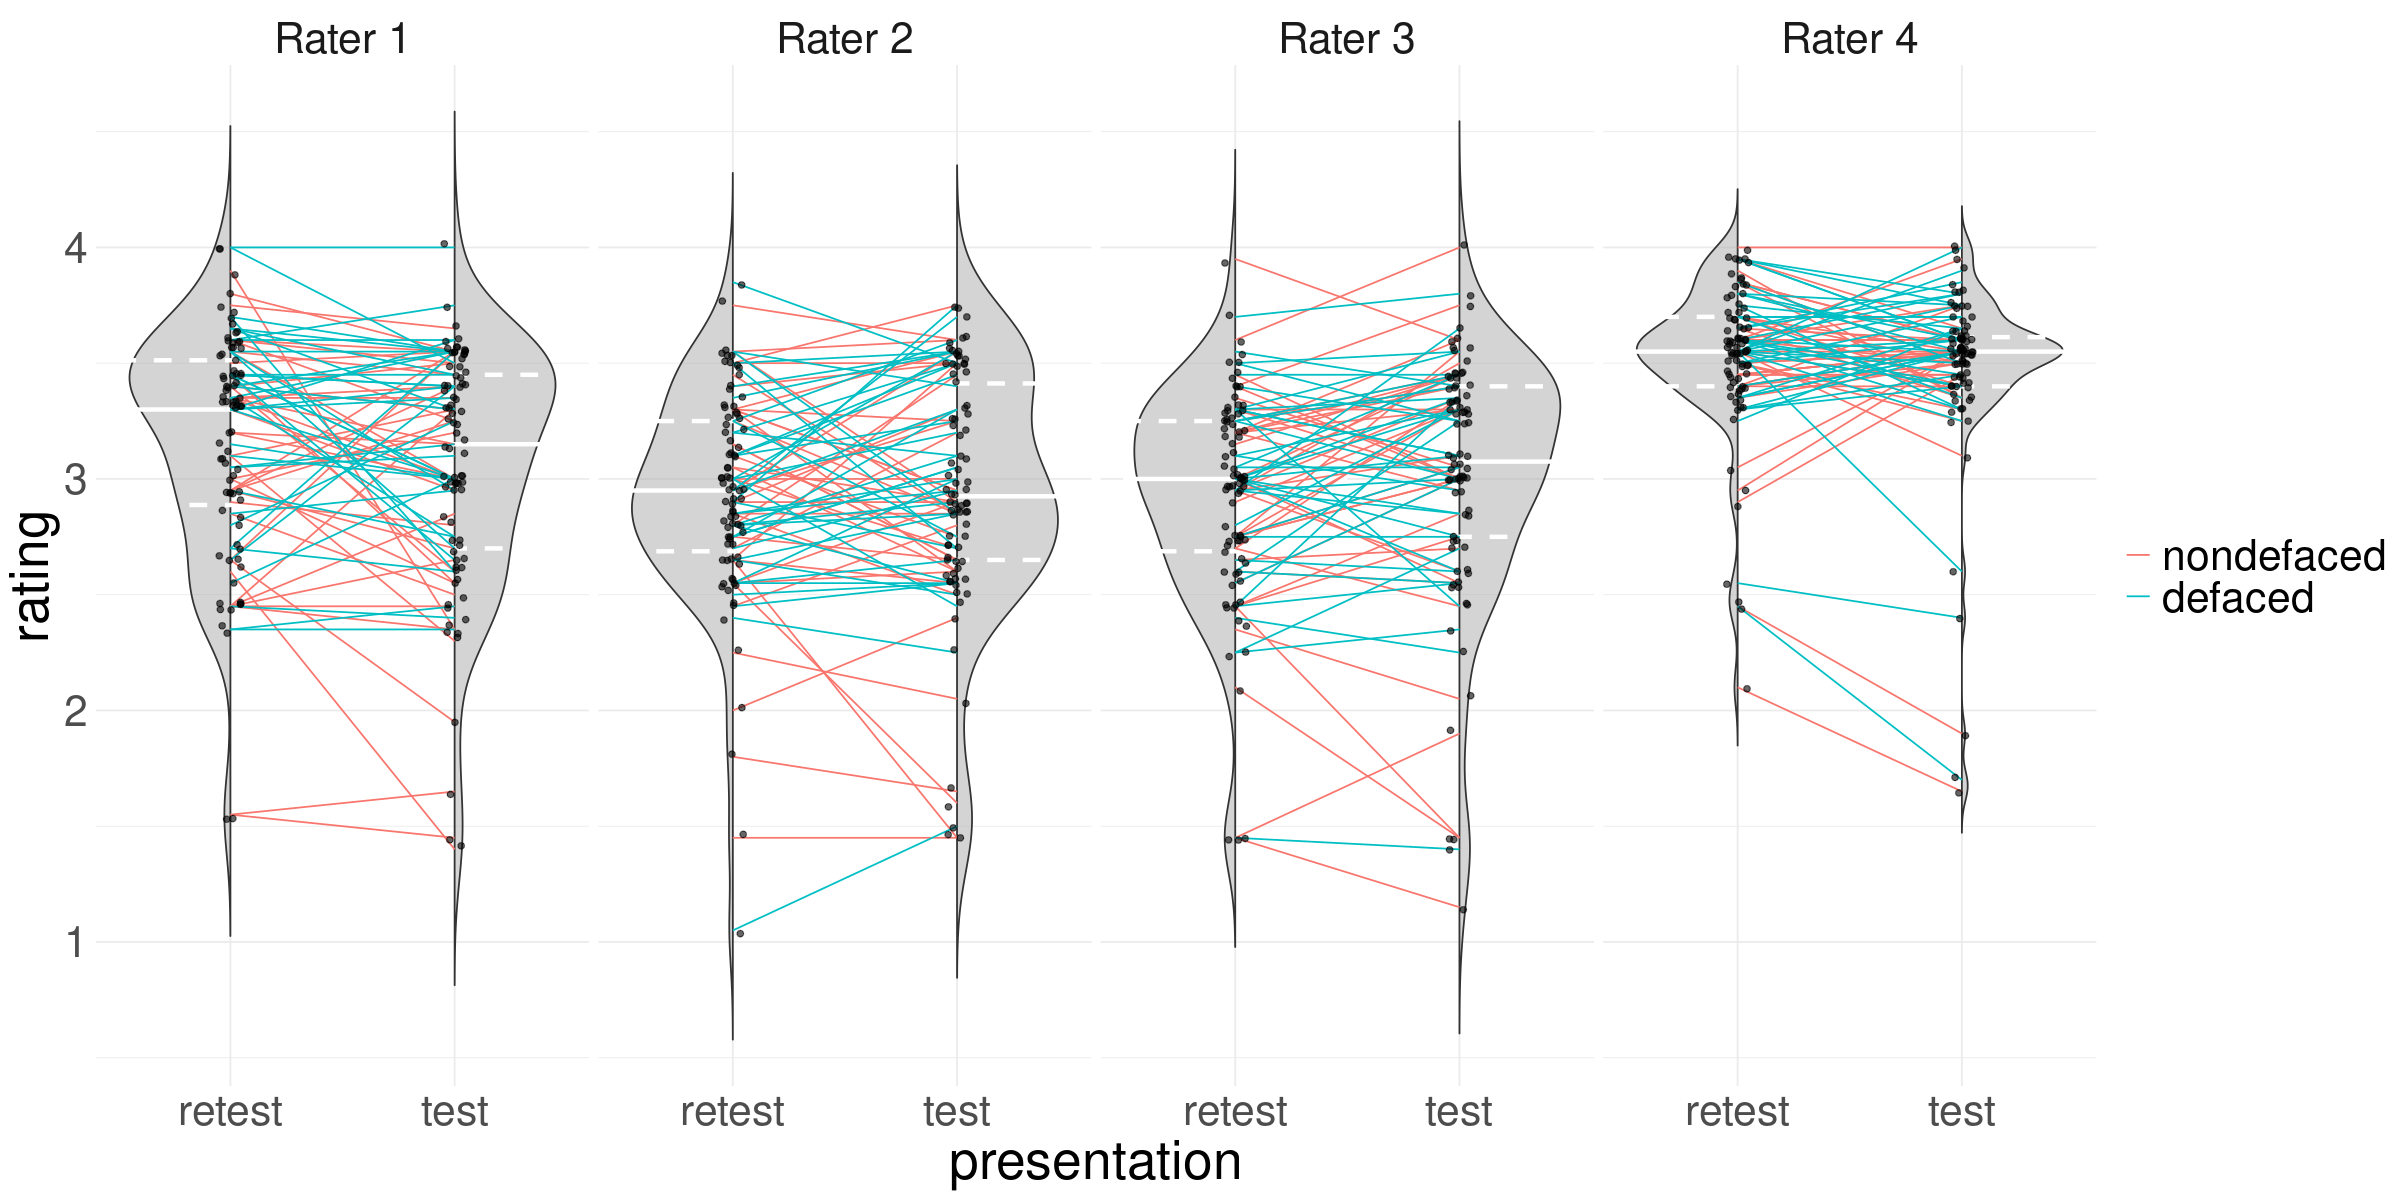

In [20]:
p <- ggplot(df_intra, aes(x = presentation, y = rating, group = presentation)) +
  geom_violinhalf(aes(fill = presentation), trim = FALSE, scale = "width", alpha = 0.5, flip=c(0,1), fill = "darkgrey") +
  stat_summary(fun = quantile, fun.args = list(probs = c(0.5)), geom = "crossbar", width=1, color="white") +
  stat_summary(fun = quantile, fun.args = list(probs = c(0.25, 0.75)), geom = "crossbar", width=1, color="white", linetype="dashed") +
  geom_line(aes(group = interaction(subject, is_defaced), color = is_defaced), alpha = 1) +
  geom_point(position = position_jitter(width = 0.05), alpha = 0.6) +
  theme_minimal() +
  theme(text = element_text(size = 32)) +
  theme(legend.title = element_blank()) +
  facet_wrap(~ rater_label, ncol = 4)

ggsave(file = "../../outputs/ManualRatings/S6_figure.svg", width = width, height = height, plot = p, dpi = 320, bg="white")
ggsave(file = "../../outputs/ManualRatings/S6_figure.tif", width = width, height = height, plot = p, dpi = 320, bg="white")
ggsave(file = "../../outputs/ManualRatings/S6_figure.png", width = width, height = height, plot = p, dpi = 320, bg="white")

print(p)

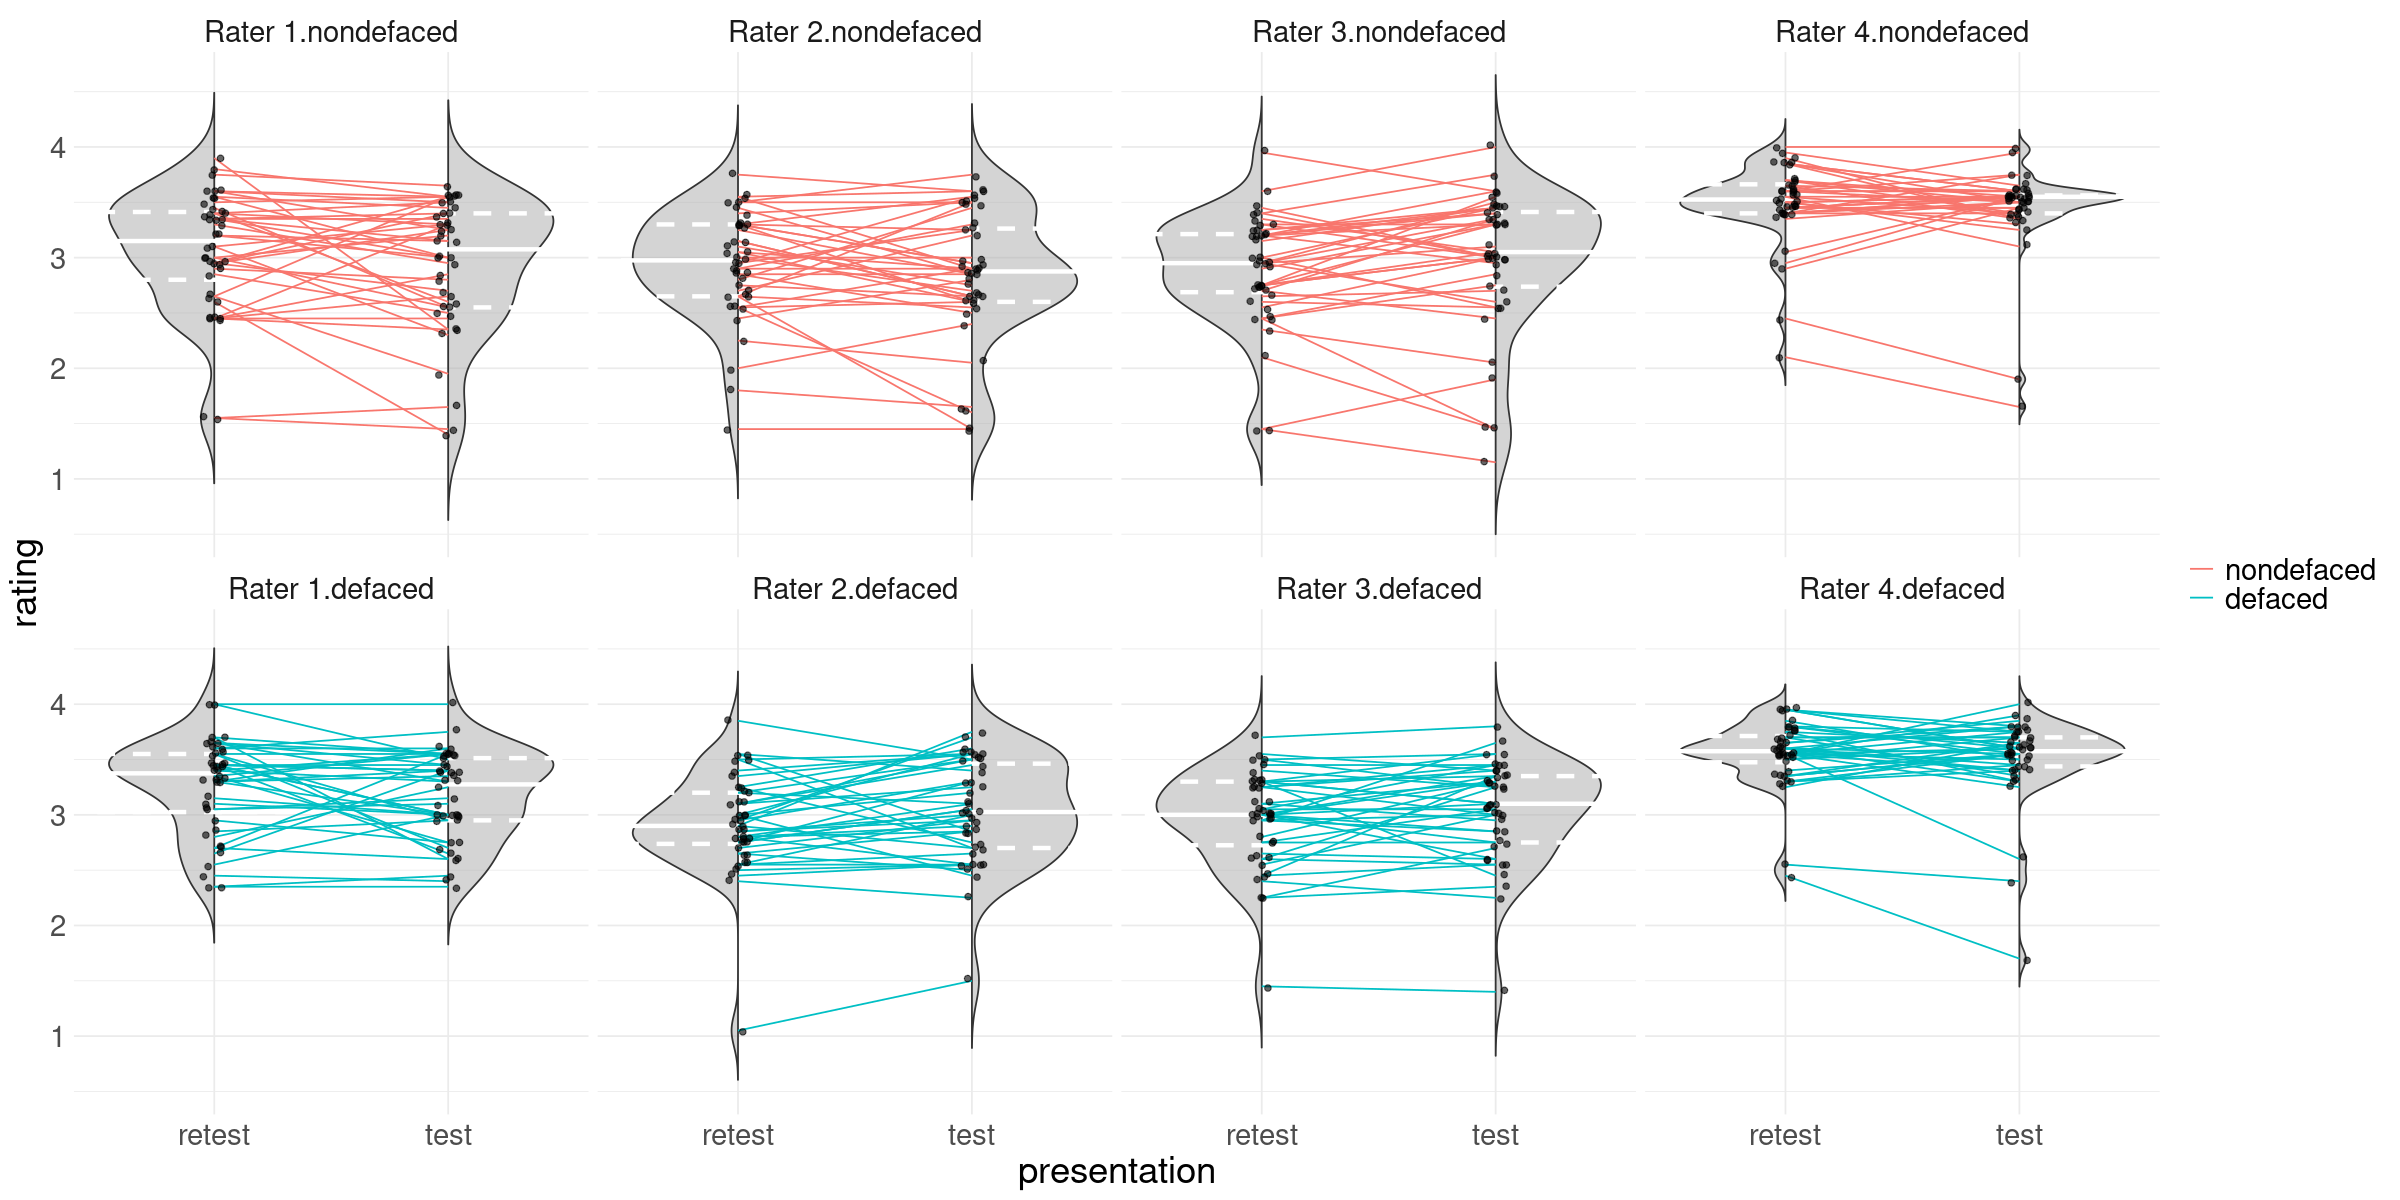

In [21]:
p <- ggplot(df_intra, aes(x = presentation, y = rating, group = presentation)) +
  geom_violinhalf(aes(fill = presentation), trim = FALSE, scale = "width", alpha = 0.5, flip=c(0,1), fill = "darkgrey") +
  stat_summary(fun = quantile, fun.args = list(probs = c(0.5)), geom = "crossbar", width=1, color="white") +
  stat_summary(fun = quantile, fun.args = list(probs = c(0.25, 0.75)), geom = "crossbar", width=1, color="white", linetype="dashed") +
  geom_line(aes(group = interaction(subject, is_defaced), color = is_defaced), alpha = 1) +
  geom_point(position = position_jitter(width = 0.05), alpha = 0.6) +
  theme_minimal() +
  theme(legend.title = element_blank()) +
  theme(text = element_text(size = 22)) +
  facet_wrap(~ interaction(rater_label, is_defaced), ncol = 4)

print(p)

## Bland-Altman plot with mean on x-axis

[1] "Biases:"
[[1]]
[1] 0.11375

[[2]]
[1] -0.009375

[[3]]
[1] -0.07875

[[4]]
[1] 0.05125

[[5]]
[1] 0.01921875



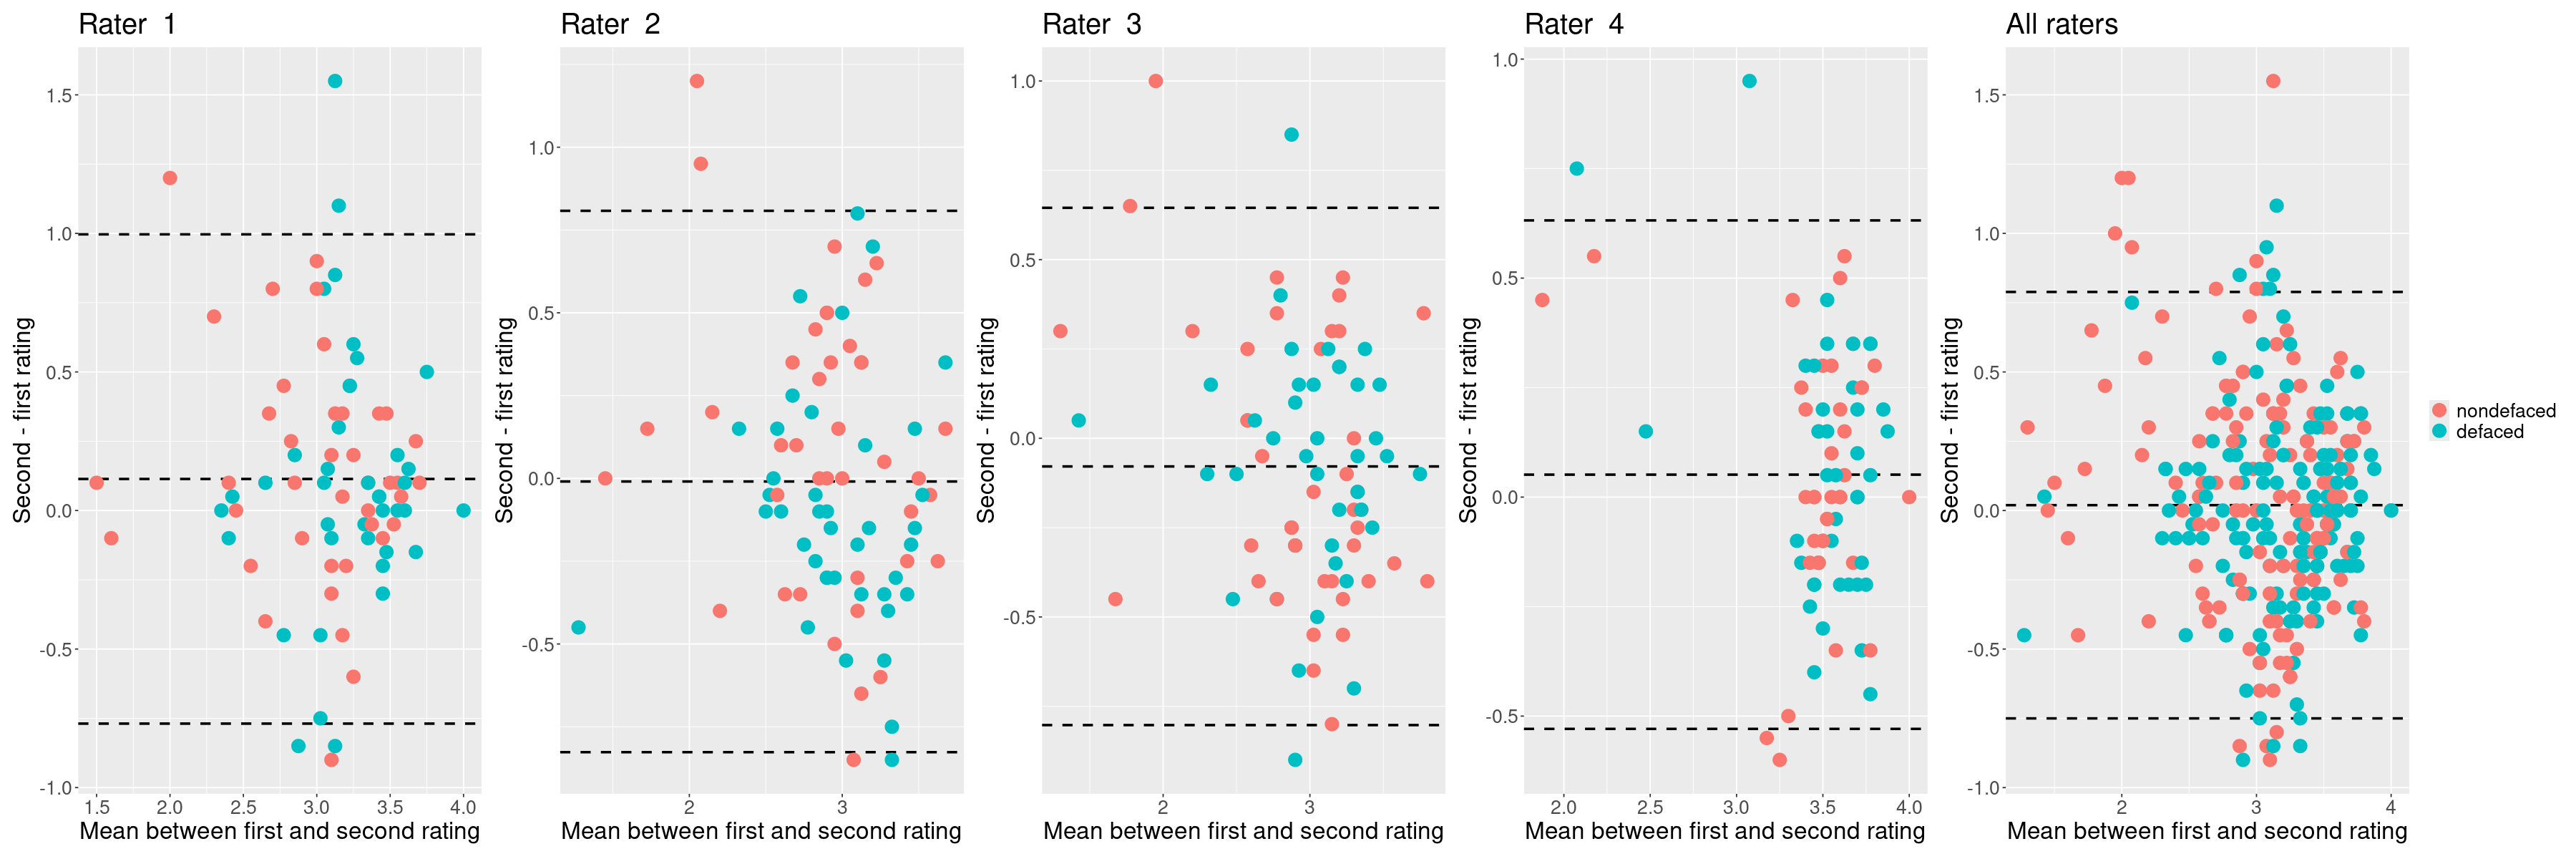

In [22]:
library(patchwork)
library(BlandAltmanLeh)

## BA for each rater separately
#extract list of unique value in df$rater_id
plot_list <- list()
biases <- list()
for (rater in sort(unique(df$rater_id))) {
  #Keep only the rows corresponding to the rater and defaced condition
  df_rater <- subset(df_intra, rater_id == rater)
  df_rater_wide <- df_rater %>%
    pivot_wider(names_from = presentation, values_from = rating)
  
  #Compute bias which corresponds to mean difference
  df_rater_wide <- df_rater_wide %>%
    mutate(deltas = retest - test)
  biases <- c(biases, list(mean(df_rater_wide$deltas)))

  ba <- bland.altman.plot(
    df_rater_wide$retest,
    df_rater_wide$test,
    graph.sys = "ggplot2",
    two = 2.0
  ) +
    # geom_hline(yintercept = mean(df_rater_wide$deltas), linetype = "solid", color = "black", size=1.2) +
    geom_point(aes(color = df_rater_wide$is_defaced), size = 5) +
    theme(text = element_text(size = 20)) +
    xlab("Mean between first and second rating") +
    ylab("Second - first rating") +
    ggtitle(paste("Rater ", strsplit(rater, "_0")[[1]][[2]])) +
    theme(legend.position = "none")

  plot_list <- c(plot_list, list(ba))
}

## BA plot with all raters
df_wide_ba_pres <- df_intra %>%
  pivot_wider(names_from = presentation, values_from = rating)

# Compute bias which corresponds to mean difference
df_wide_ba_pres <- df_wide_ba_pres %>%
  mutate(deltas = retest - test)
biases <- c(biases, list(mean(df_wide_ba_pres$deltas)))

ba_all <- bland.altman.plot(
  df_wide_ba_pres$retest,
  df_wide_ba_pres$test,
  graph.sys = "ggplot2",
  two = 2.0
) +
    # geom_hline(yintercept = mean(df_wide_ba_pres$deltas), linetype = "solid", color = "black", size=1.2) +
    geom_point(aes(color = df_wide_ba_pres$is_defaced), size = 5) +
    theme(
      text = element_text(size = 20),
      legend.title = element_blank()  # Remove the legend title
    ) +
    xlab("Mean between first and second rating") +
    ylab("Second - first rating") +
    ggtitle("All raters")

plot_list <- c(plot_list, list(ba_all))

## Combine plots
combined_plot <- wrap_plots(plot_list, ncol = 5) 

height <- 10
width <- 30

# Set a new figure size for BA plots
options(repr.plot.width = width, repr.plot.height = height)

ggsave(file = "../../outputs/ManualRatings/S7_figure.svg", width = width, height = height, plot = combined_plot, dpi = 320, bg="white")
ggsave(file = "../../outputs/ManualRatings/S7_figure.tif", width = width, height = height, plot = combined_plot, dpi = 320, bg="white")
ggsave(file = "../../outputs/ManualRatings/S7_figure.png", width = width, height = height, plot = combined_plot, dpi = 320, bg="white")

print(combined_plot)

print("Biases:")
print(biases)

## Bland-Altman plot with first ratings on x-axis

In [23]:
#Helper function to generate BA plot
ba_plot_intrarater <- function(df, title, rater, point_size = 2.5, color_1="#F5C241", color_2="#643296", line_color="grey", yaxis = "deltas") {

  # Pivot to wide format
  df_wide_ba_pres <- df %>%
      pivot_wider(names_from = presentation, values_from = rating, values_fn = list)

  #Decouple the duplicates by writing the first image rating in one line and the second in a new line
  df_wide_ba_pres <- df_wide_ba_pres %>%
    unnest(cols = c("test", "retest"))

  df_wide_ba_pres <- df_wide_ba_pres %>%
    mutate(mean = test,
          deltas = test - retest,
          pt_color = case_when(
            deltas < -0.5 ~ color_2,
            deltas > 0.5 ~ color_1,
            deltas > 0.1 ~ color_12,
            deltas < -0.1 ~ color_22,
            TRUE ~ color_reliable
          ))

  if (!missing(rater)) {
    #Keep only the rows corresponding to the rater
    df_rater <- subset(df, rater_id == rater)

    #Pivot to wide format
    df_rater_wide <- df_rater %>%
      pivot_wider(names_from = presentation, values_from = rating, values_fn = list)

    #Decouple the duplicates by writing the first image rating in one line and the second in a new line
    df_rater_wide <- df_rater_wide %>%
      unnest(cols = c("test", "retest"))

    #Create a new column encoding the mean and color to plot the points
    df_rater_wide <- df_rater_wide %>%
      mutate(mean = test,
            deltas = test - retest,
            pt_color = case_when(
              deltas < -0.5 ~ color_2,
              deltas > 0.5 ~ color_1,
              deltas > 0.1 ~ color_12,
              deltas < -0.1 ~ color_22,
              TRUE ~ color_reliable
          ))

    # Calculate mean difference and 1.96 times the standard deviation of the differences
    mean_diff <- mean(df_rater_wide$deltas)
    sd_diff <- sd(df_rater_wide$deltas)
    upper_limit <- mean_diff + 1.96 * sd_diff
    lower_limit <- mean_diff - 1.96 * sd_diff

    if (yaxis == "deltas"){
    ba <- ggplot(df_rater_wide, aes(x = mean, y = deltas)) +
      geom_point(data = df_wide_ba_pres, aes(x = mean, y = deltas, color="#d9d9d9"), alpha = 0.3, size=point_size) +
      geom_point(size = point_size, aes(color = pt_color))
    } else if (yaxis == "retest") {
      ba <- ggplot(df_rater_wide, aes(x = mean, y = retest)) +
      geom_point(data = df_wide_ba_pres, aes(x = mean, y = retest, color="#d9d9d9"), alpha = 0.3, size = point_size) +
      geom_point(size = point_size, aes(color = pt_color)) +
      geom_segment(aes(x = 1, y = 1, xend = 4.05, yend = 4.05), linetype = "dashed", color = color_reliable)
    }
  } else {
    # Calculate mean difference and 1.96 times the standard deviation of the differences
    mean_diff <- mean(df_wide_ba_pres$deltas)
    sd_diff <- sd(df_wide_ba_pres$deltas)
    upper_limit <- mean_diff + 1.96 * sd_diff
    lower_limit <- mean_diff - 1.96 * sd_diff

    if (yaxis == "deltas"){
      ba <- ggplot(df_wide_ba_pres, aes(x = mean, y = deltas)) +
        geom_point(size = point_size +1, aes(color = pt_color))
    } else if (yaxis == "defaced") {
      ba <- ggplot(df_wide_ba_pres, aes(x = mean, y = retest)) +
        geom_point(size = point_size +1, aes(color = pt_color)) +
        geom_segment(aes(x = 1, y = 1, xend = 4.05, yend = 4.05), linetype = "dashed", color = color_reliable)
    }
  }

  ba <- ba +
    # geom_hline(yintercept = 0, color = "#7f7f7f", linetype = "solid", size = 1) +
    # geom_hline(yintercept = mean_diff, color = line_color, linetype = "solid", size = 1) +
    # geom_hline(yintercept = upper_limit, color = line_color, linetype = "dashed", size = 1) +
    # geom_hline(yintercept = lower_limit, color = line_color, linetype = "dashed", size = 1) +
    scale_color_identity() +
    theme(legend.position = "none") +
    # theme(text = element_text(size = 19, face="bold")) +
    theme(
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
    ) +
    theme(panel.background = element_blank()) +
    xlab("") +
    ylab("")

  if (!missing(title)) {
    # ba <- ba + ggtitle(title)
    write_y <- if (yaxis == "deltas") 2.0 else 4.4
    ba <- ba + annotate(
      "text",
      label = title,
      x = 3.9, # max(df_wide_ba_pres$nondefaced),
      y = write_y,  # min(df_wide_ba_pres$deltas),
      hjust = 1,
      size = 10,
      fontface = 1,
    )
  }

  if (yaxis=="deltas"){
    ba <- ba + 
      xlim(0.9, 4.1) +
      ylim(-2.1, 2.1)
  }

  return(ba)
}

ba_figure_intrarater <- function(df, title) {
  library(ggplot2)
  library(grid)
  library(gridExtra)
  library(dplyr)
  library(scales)
  options(repr.plot.width=13, repr.plot.height=8)

  plot_list <- list()

  point_size <- 2.5

  ## BA plot with all raters
  ba_all <- ba_plot_intrarater(df = df, title = "All raters")

  ba_all <- ba_all +
      geom_segment(
        x = 1.2, y = -1.6,
        xend = 4.0, yend = -1.6,
        lineend = "round", # See available arrow types in example above
        linejoin = "round",
        size = 0.8, 
        arrow = arrow(length = unit(0.1, "inches"), type="closed"),
        colour = "black",
      )

  if (title == "nondefaced"){
    # Assuming ba_nd and ba_d are your initial ggplot objects
    ba_all <- ba_all +
      geom_segment(
        x = 0.95, y = 0.52,
        xend = 0.95, yend = 2.0,
        lineend = "round",
        linejoin = "round",
        size = 1, 
        arrow = arrow(length = unit(0.1, "inches"), type="closed"),
        colour = color_1
      ) +
      geom_segment(
        x = 0.95, y = 0.52,
        xend = 0.99, yend = 0.52,
        color = color_1,
        size = 1
      ) +
      geom_segment(
        x = 0.95, y = -0.52,
        xend = 0.95, yend = -2.0,
        lineend = "round",
        linejoin = "round",
        size = 1, 
        arrow = arrow(length = unit(0.1, "inches"), type="closed"),
        colour = color_2
      ) +
      geom_segment(
        x = 0.95, y = -0.52,
        xend = 0.99, yend = -0.52,
        color = color_2,
        size = 1
      ) +
      geom_segment(
        x = 0.95, y = -0.48,
        xend = 0.95, yend = 0.48,
        color = "#7f7f7f",
        size = 1
      ) +
      geom_segment(
        x = 0.95, y = -0.48,
        xend = 0.99, yend = -0.48,
        color = "#7f7f7f",
        size = 1
      ) +
      geom_segment(
        x = 0.95, y = 0.48,
        xend = 0.99, yend = 0.48,
        color = "#7f7f7f",
        size = 1
      )
  } 

  # Adjust plot margins
  ba_all <- ba_all + theme(
    plot.margin = unit(c(1,0,0,1), "cm"),
  )

  plot_list <- c(list(ba_all), plot_list)

  ## BA for each rater
  for (rater in sort(unique(df$rater_id))) {
    rater_title = paste("Rater ", strsplit(rater, "_0")[[1]][[2]])
    ba  <- ba_plot_intrarater(df = df, title = rater_title, rater = rater)
    plot_list <- c(plot_list, list(ba))
  }
  
  lay <- rbind(c(1,1,1,2,2,3,3),
              c(1,1,1,4,4,5,5))
  final_plot <- grid.arrange(
    grobs = plot_list,
    # bottom=x_grob,
    # left=y_grob,
    layout_matrix = lay,
    )

  return(final_plot)
}

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


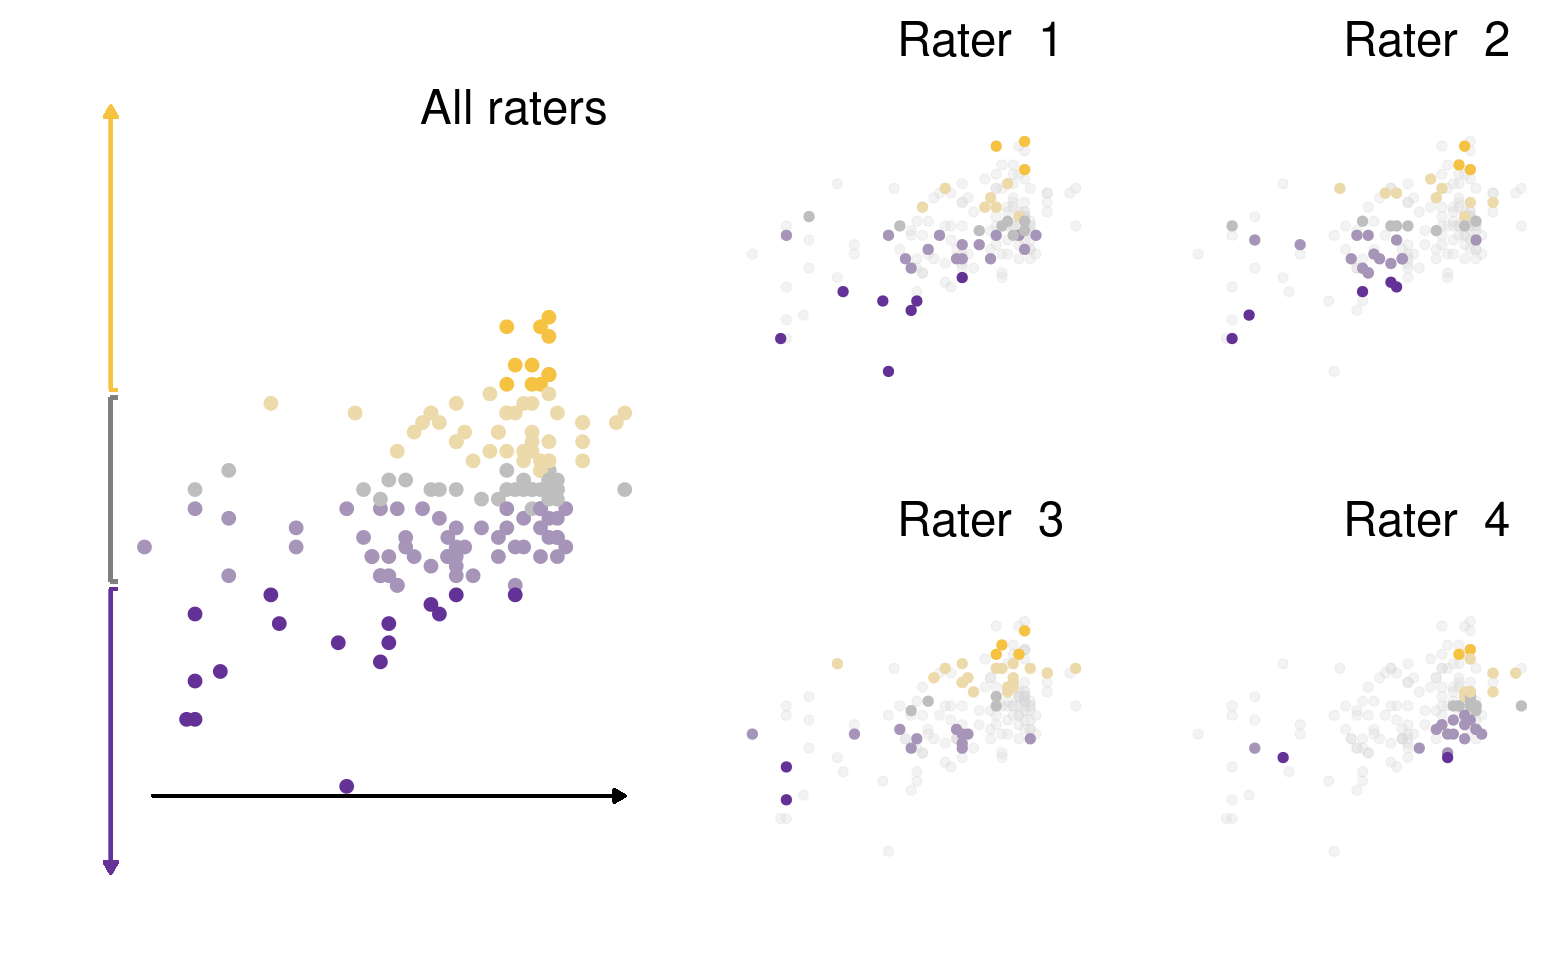

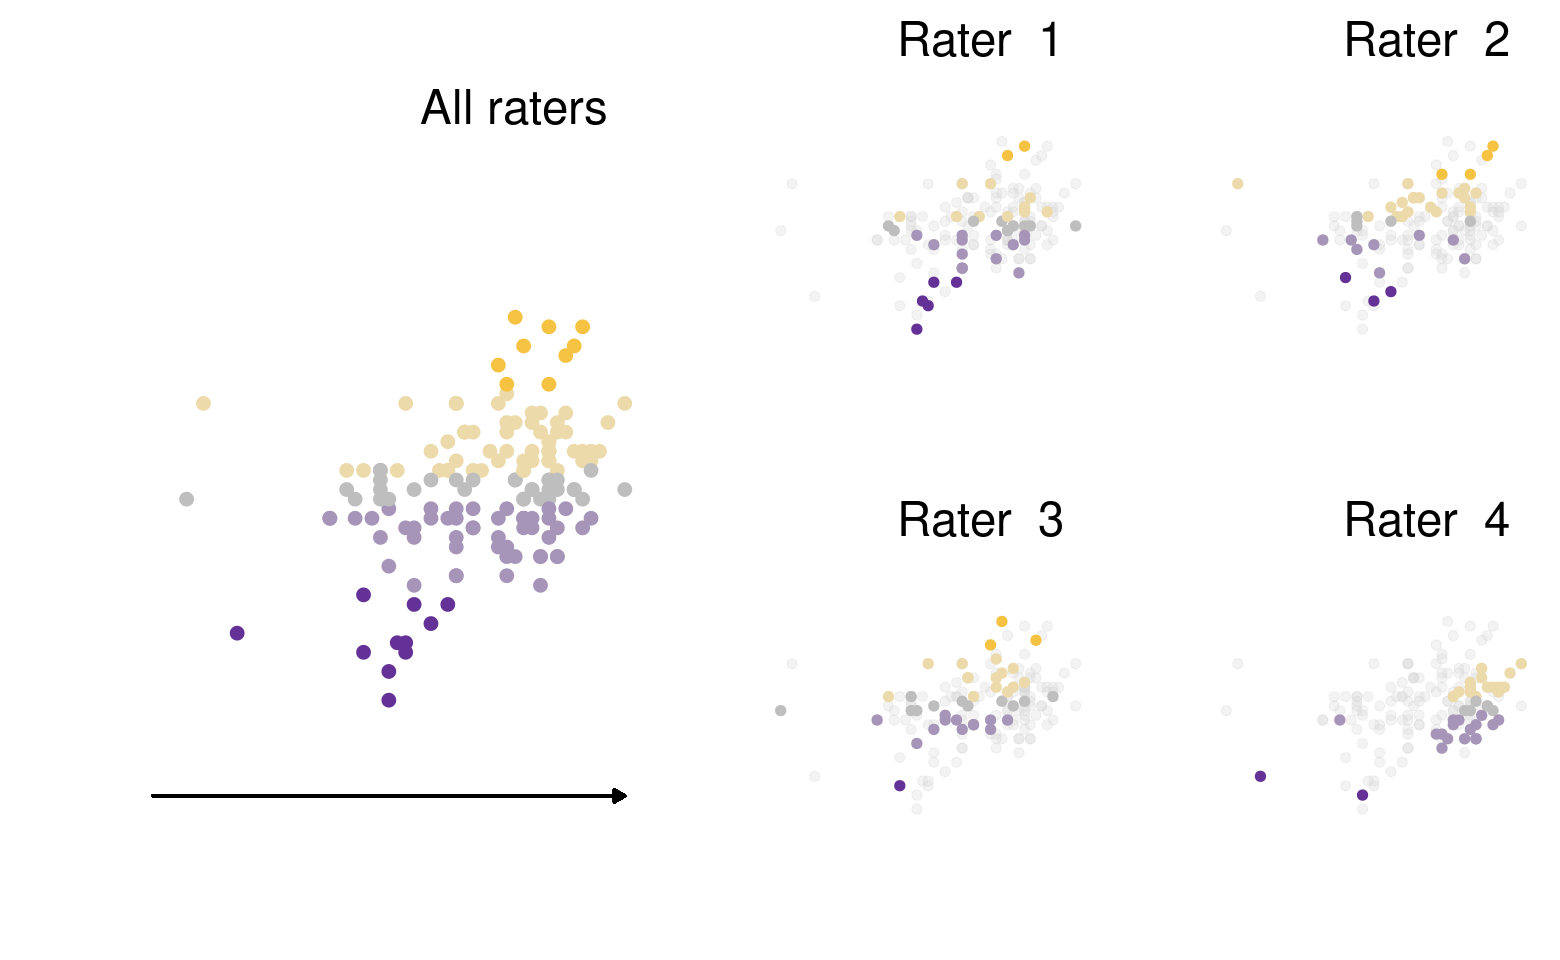

In [24]:
color_1 <- "#F5C241"
color_2 <- "#643296"
color_12 <- "#EDDAAA"
color_22 <- "#A695B8"
color_reliable <- "gray"

ba_nd <- ba_figure_intrarater(subset(df_intra, is_defaced == "nondefaced"), title="nondefaced")
ba_d <- ba_figure_intrarater(subset(df_intra, is_defaced == "defaced"), title="defaced")

options(repr.plot.width=26, repr.plot.height=8)

# Create text annotations
comment_grob <- textGrob(
  "Second\noverestimated",
  gp = gpar(fontsize = 23, col= color_2, lineheight = 0.8),
  rot = 90,
  x = 0.007,
  y = 0.25,
  just = c("centre", "top")
)
comment_grob_2 <- textGrob(
  "Second\nunderestimated",
  gp = gpar(fontsize = 23, col= color_1, lineheight = 0.8),
  rot = 90,
  x = 0.007,
  y = 0.75,
  just = c("centre", "top")
)
comment_grob_3 <- textGrob(
  "Consistent\nratings",
  gp = gpar(fontsize = 23, col = "#7f7f7f", lineheight = 0.8),
  rot = 90,
  x = 0.007,
  y = 0.5,
  just = c("centre", "top")
)

comment_grob_xaxis1 <- textGrob(
    "x-axis shows first ratings\n('excellent' ratings to the right)",
    gp = gpar(fontsize = 18, col = "black", lineheight = 0.8),
    x = 0.13,
    y = 0.165,
    just = c("centre", "top"))

comment_grob_xaxis2 <- textGrob(
    "x-axis shows first ratings\n('excellent' ratings to the right)",
    gp = gpar(fontsize = 18, col = "black", lineheight = 0.8),
    x = 0.63,
    y = 0.165,
    just = c("centre", "top"))

title_grob1 <- textGrob("nondefaced", 
    gp = gpar(fontsize = 32, fontface = 2), 
    x = 0.01,
    y = 0.98,
    just = c("left", "top")
  )

title_grob2 <- textGrob("defaced", 
    gp = gpar(fontsize = 32, fontface = 2), 
    x = 0.55,
    y = 0.98,
    just = c("left", "top")
  )

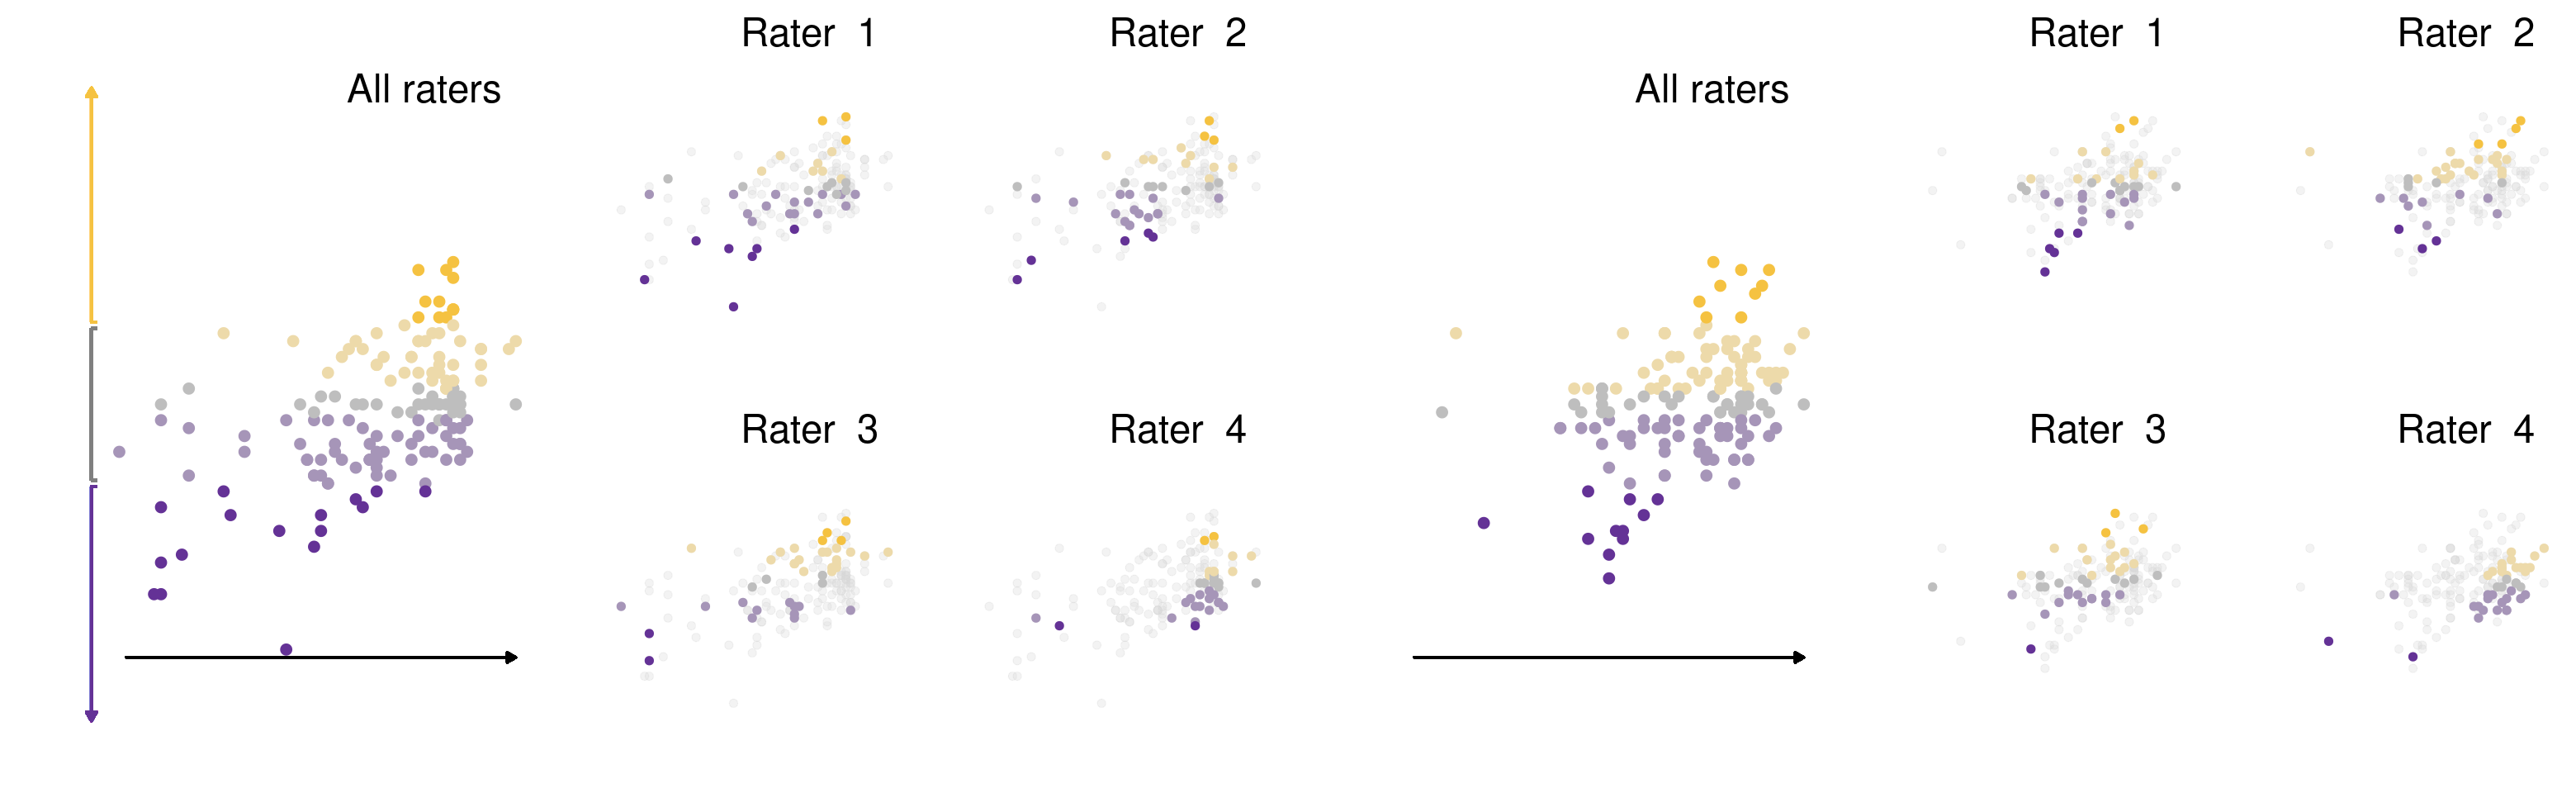

In [25]:
# Combine the plots into a single figure
combined_plot <- grid.arrange(ba_nd, ba_d, ncol = 2)

# Create a grobTree containing the combined plot and all annotations
combined_grob <- grobTree(
  combined_plot,
  comment_grob,
  comment_grob_2,
  comment_grob_3,
  comment_grob_xaxis1,
  comment_grob_xaxis2,
  title_grob1,
  title_grob2
)

height <- 10
width <- 30

# Set a new figure size for BA plots
options(repr.plot.width = width, repr.plot.height = height)

ggsave(file = "../../outputs/ManualRatings/S8_figure.svg", width = width, height = height, plot = combined_grob, dpi = 320, bg="white")
ggsave(file = "../../outputs/ManualRatings/S8_figure.tif", width = width, height = height, plot = combined_grob, dpi = 320, bg="white")
ggsave(file = "../../outputs/ManualRatings/S8_figure.png", width = width, height = height, plot = combined_grob, dpi = 320, bg="white")

## Intra-rater reliability

Let's quantify intra-rater reliability using intraclass correlation (ICC)

In [26]:
#To compute ICC, the data needs to be in wide format
df_intra_wide <- df_intra %>%
  pivot_wider(names_from = presentation, values_from = rating)

#Add a column that encodes the interaction between defaced and subject
df_intra_wide$image <- interaction(df_intra_wide$is_defaced, df_intra_wide$subject)
df_intra_wide$is_defaced <- NULL
df_intra_wide$subject <- NULL
df_intra_wide$rater_label <- NULL
head(df_intra_wide)

rater_id test retest image         
1 rater_02 2.55 2.55   defaced.72    
2 rater_02 2.95 2.85   defaced.248   
3 rater_02 2.55 2.65   nondefaced.437
4 rater_02 2.60 3.05   nondefaced.614
5 rater_02 2.65 2.75   nondefaced.525
6 rater_02 3.55 3.00   defaced.335

In [27]:
df_intra_wide$image <- NULL

#extract list of unique value in df$rater_id
for (rater in unique(df$rater_id)) {
  #Keep only the rows corresponding to the rater
  df_rater <- subset(df_intra_wide, rater_id == rater)
  df_rater$rater_id <- NULL

  print(sprintf('Intra-rater reliability for %s', rater))
  print(icc(df_rater, model="twoway", type="agreement"))
}

df_intra_wide$rater_id <- NULL
print('Intra-rater reliability for all rater combined')
print(icc(df_intra_wide, model="twoway", type="agreement"))

[1] "Intra-rater reliability for rater_02"
 Single Score Intraclass Correlation

   Model: twoway 
   Type : agreement 

   Subjects = 80 
     Raters = 2 
   ICC(A,1) = 0.676

 F-Test, H0: r0 = 0 ; H1: r0 > 0 
 F(79,79.1) = 5.12 , p = 2.85e-12 

 95%-Confidence Interval for ICC Population Values:
  0.536 < ICC < 0.779
[1] "Intra-rater reliability for rater_03"
 Single Score Intraclass Correlation

   Model: twoway 
   Type : agreement 

   Subjects = 80 
     Raters = 2 
   ICC(A,1) = 0.746

 F-Test, H0: r0 = 0 ; H1: r0 > 0 
 F(79,75.6) = 7.09 , p = 8.37e-16 

 95%-Confidence Interval for ICC Population Values:
  0.63 < ICC < 0.83
[1] "Intra-rater reliability for rater_01"
 Single Score Intraclass Correlation

   Model: twoway 
   Type : agreement 

   Subjects = 80 
     Raters = 2 
   ICC(A,1) = 0.609

 F-Test, H0: r0 = 0 ; H1: r0 > 0 
 F(79,72.5) = 4.29 , p = 9.88e-10 

 95%-Confidence Interval for ICC Population Values:
  0.449 < ICC < 0.731
[1] "Intra-rater reliability for rater_

Let's now quantify intra-rater reliability with respect to the defacing condition.

In [28]:
#To compute ICC, the data needs to be in wide format
# Pivot to wide format
df_wide_def <- df %>%
    pivot_wider(names_from = is_defaced, values_from = rating, values_fn = list)

#Decouple the duplicates by writing the first image rating in one line and the second in a new line
df_wide_def <- df_wide_def %>%
    unnest(cols = c("nondefaced", "defaced"))

df_wide_def$subject <- NULL
df_wide_def$rater_label <- NULL
head(df_wide_def)

rater_id defaced nondefaced
1 rater_02 2.55    2.40      
2 rater_02 2.55    2.00      
3 rater_02 2.55    2.85      
4 rater_02 3.60    2.55      
5 rater_02 3.45    3.55      
6 rater_02 2.95    3.20

In [29]:
#extract list of unique value in df$rater_id
for (rater in unique(df$rater_id)) {
  #Keep only the rows corresponding to the rater
  df_rater <- subset(df_wide_def, rater_id == rater)
  df_rater$rater_id <- NULL

  print(sprintf('Intra-rater reliability for %s', rater))
  print(icc(df_rater, model="twoway", type="agreement"))
}

df_wide_def$rater_id <- NULL
print('Intra-rater reliability for all raters combined')
print(icc(df_wide_def, model="twoway", type="agreement"))

[1] "Intra-rater reliability for rater_02"
 Single Score Intraclass Correlation

   Model: twoway 
   Type : agreement 

   Subjects = 225 
     Raters = 2 
   ICC(A,1) = 0.62

 F-Test, H0: r0 = 0 ; H1: r0 > 0 
 F(224,224) = 4.24 , p = 1.41e-25 

 95%-Confidence Interval for ICC Population Values:
  0.532 < ICC < 0.694
[1] "Intra-rater reliability for rater_03"
 Single Score Intraclass Correlation

   Model: twoway 
   Type : agreement 

   Subjects = 225 
     Raters = 2 
   ICC(A,1) = 0.68

 F-Test, H0: r0 = 0 ; H1: r0 > 0 
 F(224,215) = 5.33 , p = 5.73e-32 

 95%-Confidence Interval for ICC Population Values:
  0.603 < ICC < 0.745
[1] "Intra-rater reliability for rater_01"
 Single Score Intraclass Correlation

   Model: twoway 
   Type : agreement 

   Subjects = 225 
     Raters = 2 
   ICC(A,1) = 0.539

 F-Test, H0: r0 = 0 ; H1: r0 > 0 
 F(224,176) = 3.47 , p = 6.47e-17 

 95%-Confidence Interval for ICC Population Values:
  0.434 < ICC < 0.629
[1] "Intra-rater reliability for rat

# Inter-rater reliability

Similarly to intra-rater reliability, we will quantify inter-rater reliability using intraclass correlation (ICC).

In [30]:
df_filtered <- subset(df, select = -c(rater_label))

df_wide <- df_filtered %>%
  pivot_wider(names_from = rater_id, values_from = rating, values_fn = list, names_sort = TRUE)

In [31]:
#Decouple the duplicates by writing the first image rating in one line and the second in a new line
df_wide <- df_wide %>%
  unnest(cols = c(rater_02, rater_03, rater_04, rater_01))
nrow(df_wide)
head(df_wide)


[1] 450

is_defaced subject rater_01 rater_02 rater_03 rater_04
1 defaced     72     2.60     2.55     3.55     2.40    
2 defaced     72     2.70     2.55     3.30     2.55    
3 nondefaced 354     3.05     2.85     3.70     3.70    
4 nondefaced 205     3.55     2.55     3.30     3.70    
5 defaced    446     3.40     3.45     3.35     3.95    
6 defaced    248     2.70     2.95     3.30     3.70

In [32]:
df_wide$defaced <- NULL
df_wide$subject <- NULL
print(icc(df_wide, model="twoway", type="consistency"))

Warning message in is.data.frame(x):
“NAs introduced by coercion”
Warning message in mean.default(newX[, i], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(newX[, i], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(newX[, i], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(newX[, i], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(newX[, i], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(newX[, i], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(newX[, i], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(newX[, i], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(newX[, i], ...):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(ne

 Single Score Intraclass Correlation

   Model: twoway 
   Type : consistency 

   Subjects = 450 
     Raters = 5 
   ICC(C,1) = NA

 F-Test, H0: r0 = 0 ; H1: r0 > 0 
F(449,1796) = NA , p = NA 

 95%-Confidence Interval for ICC Population Values:
  NA < ICC < NA


# Reliability of the ratings between nondefaced and defaced conditions

In [33]:
df_filtered <- subset(df, select = -c(rater_label))

df_wide_defaced <- df_filtered %>%
  pivot_wider(names_from = is_defaced, values_from = rating, values_fn = list, names_sort = TRUE)

#Decouple the duplicates by writing the first image rating in one line and the second in a new line
df_wide_defaced <- df_wide_defaced %>%
  unnest(cols = c("nondefaced", "defaced"))
nrow(df_wide_defaced)
head(df_wide_defaced)

df_wide_defaced$rater_id <- NULL
df_wide_defaced$subject <- NULL
print(icc(df_wide_defaced, model="twoway", type="consistency"))

[1] 900

rater_id subject nondefaced defaced
1 rater_02  72     2.40       2.55   
2 rater_02  72     2.00       2.55   
3 rater_02 354     2.85       2.55   
4 rater_02 205     2.55       3.60   
5 rater_02 446     3.55       3.45   
6 rater_02 248     3.20       2.95

 Single Score Intraclass Correlation

   Model: twoway 
   Type : consistency 

   Subjects = 900 
     Raters = 2 
   ICC(C,1) = 0.697

 F-Test, H0: r0 = 0 ; H1: r0 > 0 
 F(899,899) = 5.6 , p = 2.56e-132 

 95%-Confidence Interval for ICC Population Values:
  0.662 < ICC < 0.729


# Rating evolution through time

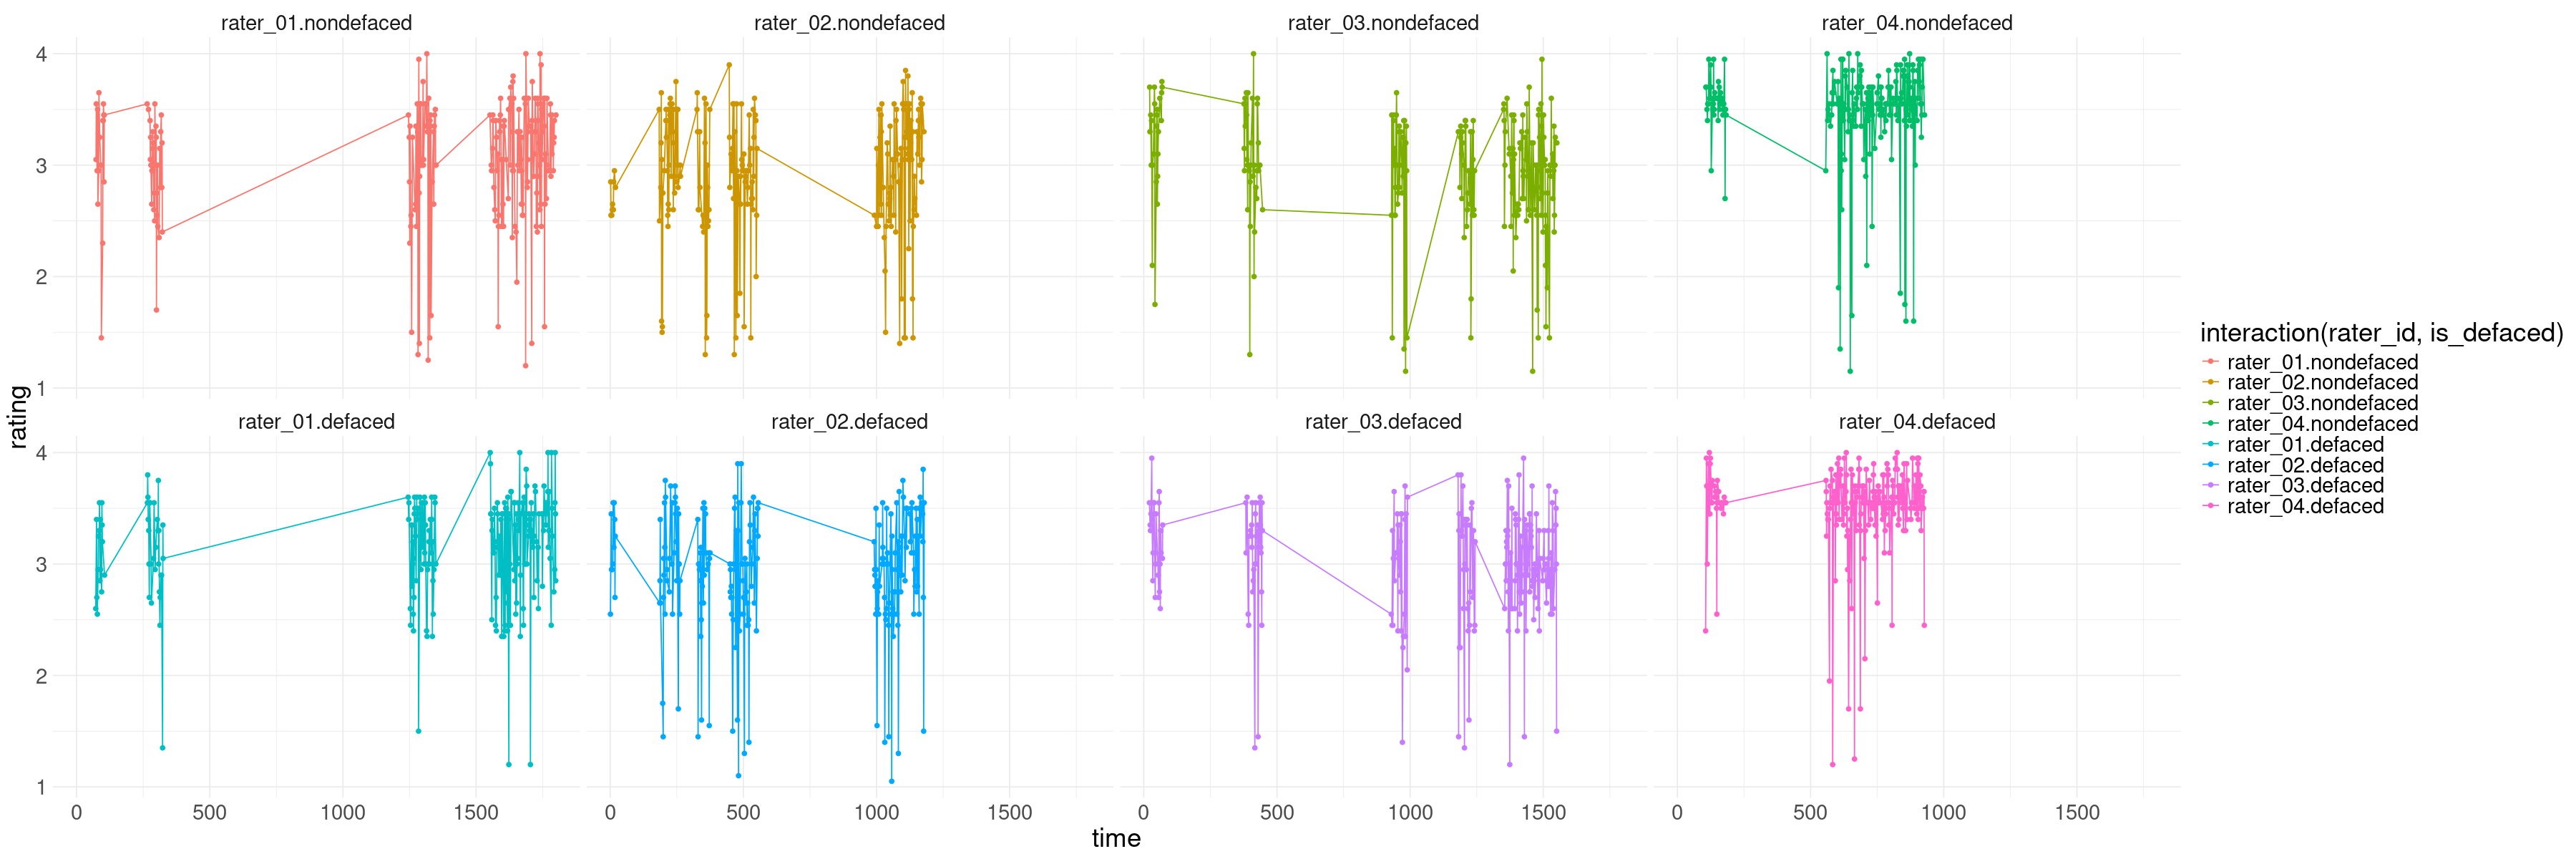

In [34]:
# For each subgroup defined by rater_id and defaced condition, plot the rating evolution through time. 
df$time <- 1:nrow(df)
p <- ggplot(df, aes(x = time, y = rating, group = interaction(rater_id, is_defaced), color = interaction(rater_id, is_defaced))) +
  geom_line() +
  geom_point() +
  theme_minimal() +
  theme(text = element_text(size = 22)) +
  facet_wrap(~ interaction(rater_id, is_defaced), ncol = 4)
print(p)

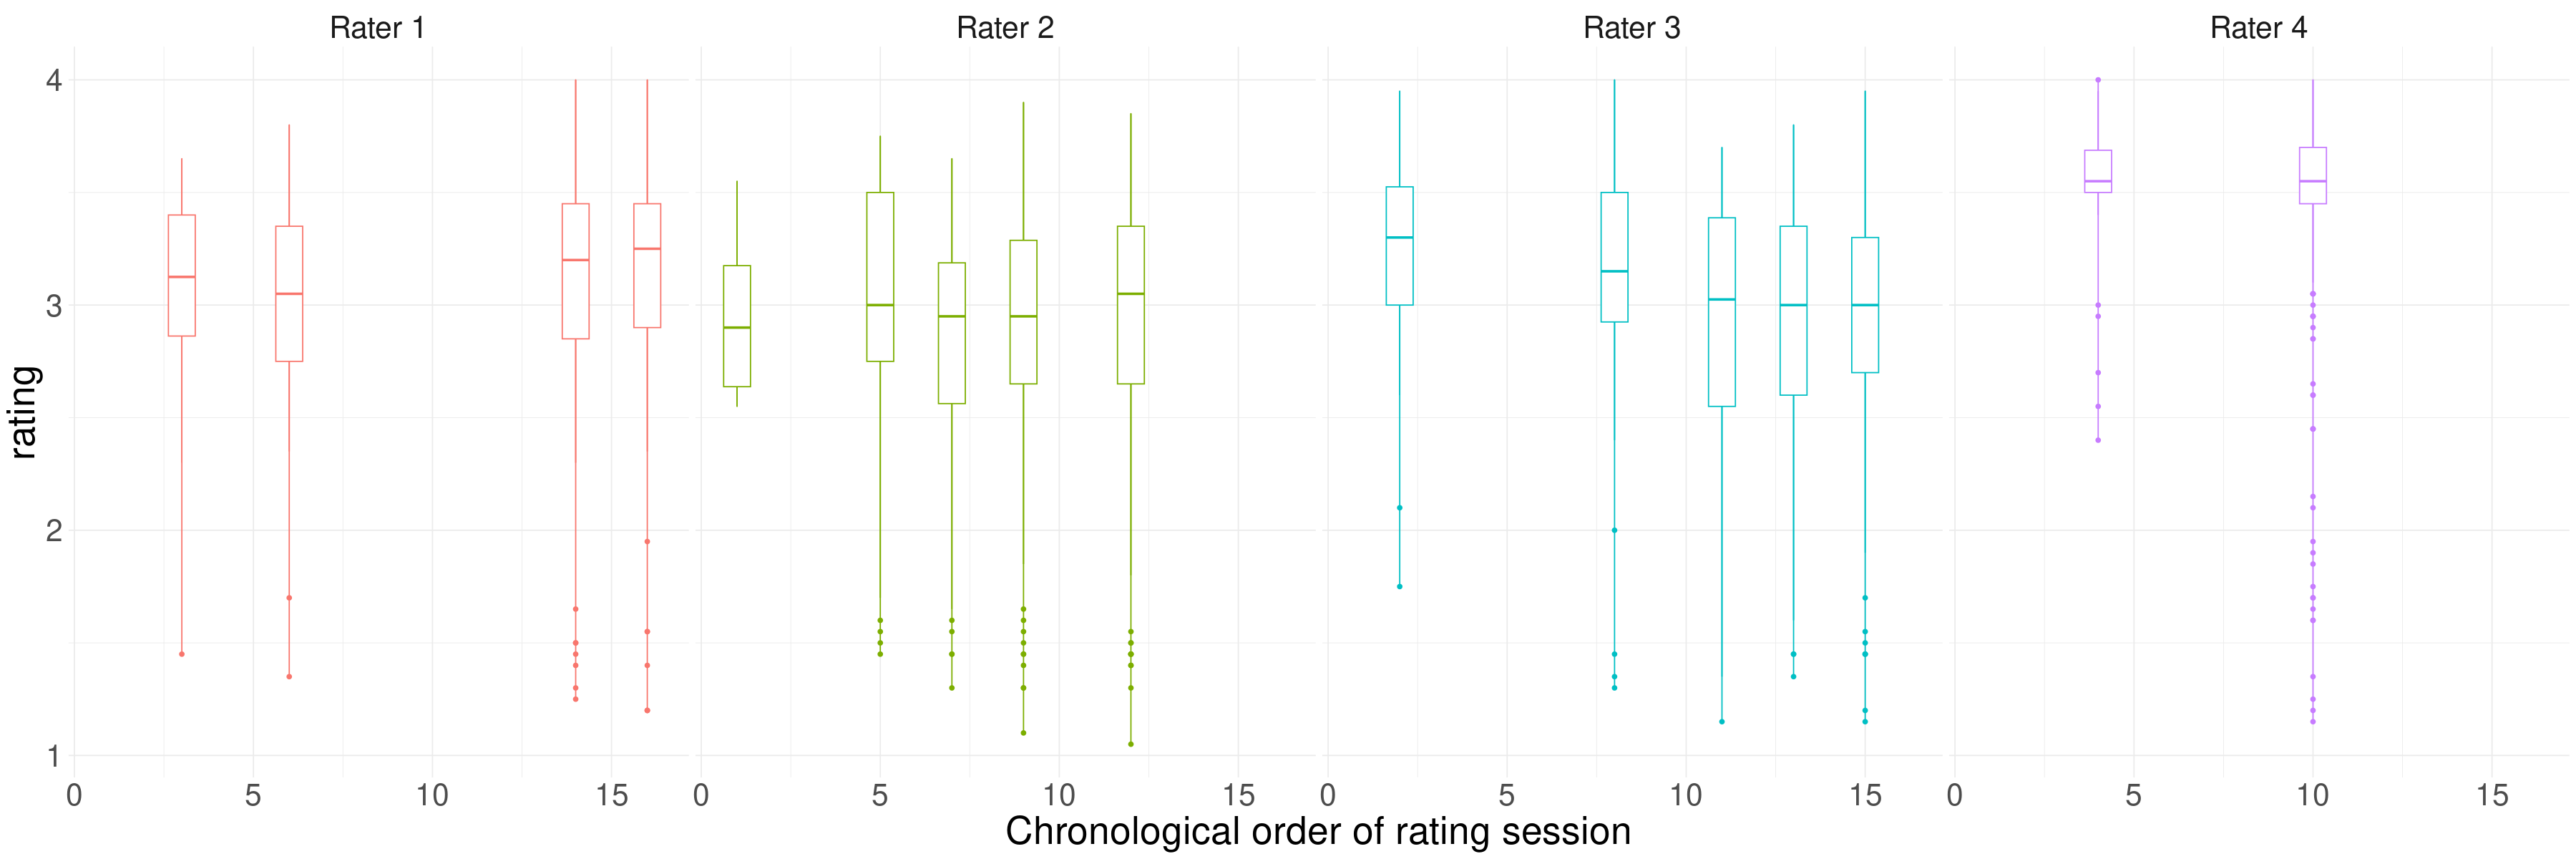

In [35]:
# Custom labeller function to format rater labels
rater_labeller <- function(rater) {
  gsub("rater_0*(\\d+)", "Rater \\1", rater)
}

#Identify blocks of ratings from the same raters
rle_blocks <- rle(as.character(df$rater_id))
df$block <- rep(seq_along(rle_blocks$lengths), rle_blocks$lengths)

#For each block, plot a boxplot of the distribution of the ratings without differentiating between defaced and nondefaced
# order the block by rater_id
p <- ggplot(df, aes(x = block, y = rating, group = block, color=rater_id)) +
  geom_line() +
  geom_boxplot() +
  theme_minimal() +
  theme(
    text = element_text(size = 32),
    legend.position = "none"  # Remove the legend
  ) +
  facet_wrap(~ rater_id, ncol = 4, labeller = labeller(rater_id = rater_labeller)) +
  labs(x = "Chronological order of rating session")

print(p)

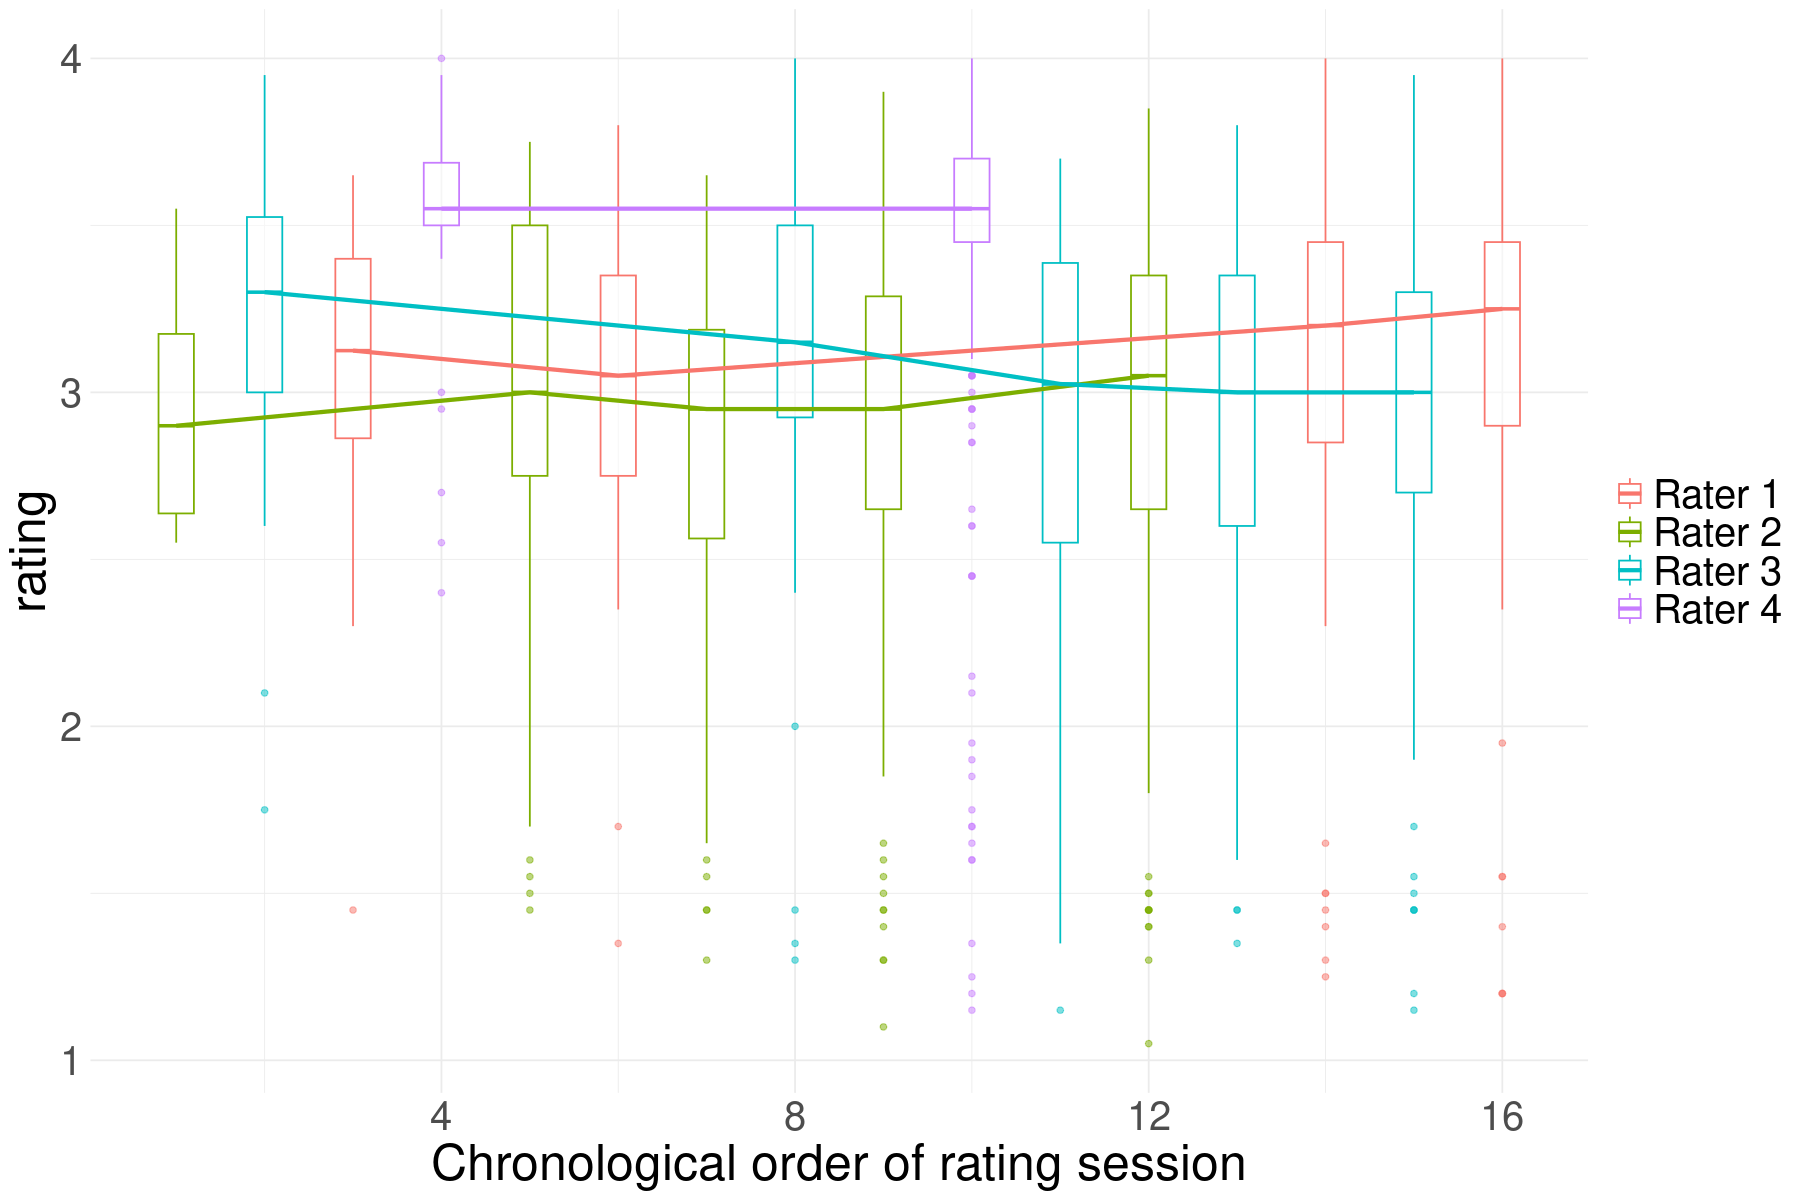

In [36]:
# Identify blocks of ratings from the same raters
rle_blocks <- rle(as.character(df$rater_id))
df$block <- rep(seq_along(rle_blocks$lengths), rle_blocks$lengths)

# Summarize the data to calculate means for each block
df_summary <- df %>%
  group_by(rater_id, block) %>%
  summarise(
    mean_rating = median(rating),
    .groups = "drop"  # Avoid grouped output warning
  )

# Relabel `rater_id` for the legend by converting to character
df <- df %>%
  mutate(rater_label = gsub("rater_0*(\\d+)", "Rater \\1", as.character(rater_id)))

df_summary <- df_summary %>%
  mutate(rater_label = gsub("rater_0*(\\d+)", "Rater \\1", as.character(rater_id)))

# Plot both boxplot and line plot
p <- ggplot(df, aes(x = block, y = rating, group = block, color = rater_label)) +
  geom_boxplot(aes(group = block), width = 0.4, alpha = 0.5) +  # Boxplot for each block
  geom_line(data = df_summary, aes(x = block, y = mean_rating, group = rater_label, color = rater_label), size = 1.2) +  # Line plot for mean ratings
  theme_minimal() +
  theme(
    text = element_text(size = 30),
    legend.title = element_blank()  # Remove the legend title
  ) +
  labs(x = "Chronological order of rating session", color = NULL)  # Ensure no legend title


height <- 10
width <- 15

# Set a new figure size for BA plots
options(repr.plot.width = width, repr.plot.height = height)

ggsave(file = "../../outputs/ManualRatings/S5_figure.svg", width = width, height = height, plot = p, dpi = 320, bg="white")
ggsave(file = "../../outputs/ManualRatings/S5_figure.tif", width = width, height = height, plot = p, dpi = 320, bg="white")
ggsave(file = "../../outputs/ManualRatings/S5_figure.png", width = width, height = height, plot = p, dpi = 320, bg="white")

print(p)